# Context
AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalized campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customer queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help

 

# Objective
To identify different segments in the existing customer, based on their spending patterns as well as past interaction with the bank, using clustering algorithms, and provide recommendations to the bank on how to better market to and service these customers.

 

# Data Description
The data provided is of various customers of a bank and their financial attributes like credit limit, the total number of credit cards the customer has, and different channels through which customers have contacted the bank for any queries (including visiting the bank, online and through a call center).

# Data Dictionary

* Sl_No: Primary key of the records
* Customer Key: Customer identification number
* Average Credit Limit: Average credit limit of each customer for all credit cards
* Total credit cards: Total number of credit cards possessed by the customer
* Total visits bank: Total number of visits that customer made (yearly) personally to the bank
* Total visits online: Total number of visits or online logins made by the customer (yearly)
* Total calls made: Total number of calls made by the customer to the bank or its customer service department (yearly)

In [1]:
# this will help in making the Python code more structured automatically (good coding practice)
%load_ext nb_black

# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

sns.set_theme()

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to perform PCA
from sklearn.decomposition import PCA

# to suppress warnings
import warnings

warnings.filterwarnings("ignore")

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)


# to compute distances
from scipy.spatial.distance import cdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from yellowbrick.cluster import InterclusterDistance
from sklearn.metrics import davies_bouldin_score

# For hierarchical clustering
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage
from scipy.spatial.distance import pdist

<IPython.core.display.Javascript object>

In [2]:
# Loading the data
data = pd.read_excel("Credit Card Customer Data.xlsx")

<IPython.core.display.Javascript object>

In [3]:
# Copying the data so I won't accidentally change the original
df = data.copy()

<IPython.core.display.Javascript object>

In [4]:
# getting rows and columns
df.shape

(660, 7)

<IPython.core.display.Javascript object>

The data has 660 entries and 7 columns for each.

In [5]:
# Looking at the first 5 rows just for a visual
df.head(5)

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


<IPython.core.display.Javascript object>

Observations:
* It seems like SI_No and Customer Key are just identifiers and we can drop both.
* SI_No can definitely be dropped, it's just a key. However, Customer Key may have meaningful duplicates because a customer could be entered twice. Let's see.

In [6]:
# Looking at data types and null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


<IPython.core.display.Javascript object>

In [7]:
# Dropping Sl_No.
df.drop("Sl_No", axis=1, inplace=True)

<IPython.core.display.Javascript object>

In [8]:
# Changing customer key's name so we can work with it better
df["Customer_Key"] = df["Customer Key"]
df.drop("Customer Key", axis=1, inplace=True)

<IPython.core.display.Javascript object>

In [9]:
# Duplicates of just customer key
df.Customer_Key.duplicated().sum()

5

<IPython.core.display.Javascript object>

In [10]:
# If that is just the same customer added twice, then every row should be identical
df.duplicated().sum()

0

<IPython.core.display.Javascript object>

This means that multiple customers were entered with differing rows. Let's pull them up.

In [11]:
# This will get us the keys that were duplicated
df[df["Customer_Key"].duplicated() == True]

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Customer_Key
332,17000,7,3,1,0,47437
398,67000,6,2,2,2,96929
432,59000,6,2,1,2,37252
541,60000,7,5,2,2,50706
632,187000,7,1,7,0,97935


<IPython.core.display.Javascript object>

Now that we have the duplicated keys, let's see how each compares to their duplicates.

In [12]:
df[df["Customer_Key"] == 47437]

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Customer_Key
4,100000,6,0,12,3,47437
332,17000,7,3,1,0,47437


<IPython.core.display.Javascript object>

In [13]:
df[df["Customer_Key"] == 96929]

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Customer_Key
391,13000,4,5,0,0,96929
398,67000,6,2,2,2,96929


<IPython.core.display.Javascript object>

In [14]:
df[df["Customer_Key"] == 37252]

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Customer_Key
48,6000,4,0,2,8,37252
432,59000,6,2,1,2,37252


<IPython.core.display.Javascript object>

In [15]:
df[df["Customer_Key"] == 50706]

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Customer_Key
411,44000,4,5,0,2,50706
541,60000,7,5,2,2,50706


<IPython.core.display.Javascript object>

In [16]:
df[df["Customer_Key"] == 97935]

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Customer_Key
104,17000,2,1,2,10,97935
632,187000,7,1,7,0,97935


<IPython.core.display.Javascript object>

Those are all extremely different. I would say these are probably different customers with erroneous keys.

I'm not going to worry about it then, and just drop Customer_Key entirely. If they'd been close I'd have considered averaging them.

In [17]:
# Dropping customer key
df.drop("Customer_Key", axis=1, inplace=True)

<IPython.core.display.Javascript object>

In [18]:
# Re-examining the remaining rows
df.head(5)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,100000,2,1,1,0
1,50000,3,0,10,9
2,50000,7,1,3,4
3,30000,5,1,1,4
4,100000,6,0,12,3


<IPython.core.display.Javascript object>

All numerical columns now, let's take a look for bad entries etc.

In [19]:
df.describe().round(1)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
count,660.0,660.0,660.0,660.0,660.0
mean,34574.2,4.7,2.4,2.6,3.6
std,37625.5,2.2,1.6,2.9,2.9
min,3000.0,1.0,0.0,0.0,0.0
25%,10000.0,3.0,1.0,1.0,1.0
50%,18000.0,5.0,2.0,2.0,3.0
75%,48000.0,6.0,4.0,4.0,5.0
max,200000.0,10.0,5.0,15.0,10.0


<IPython.core.display.Javascript object>

No obviously unreasonable min or max values. 200,000 credit limit is high but not impossible. Zero interactions is reasonable, and everyone has a credit card. The values check out.

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Avg_Credit_Limit     660 non-null    int64
 1   Total_Credit_Cards   660 non-null    int64
 2   Total_visits_bank    660 non-null    int64
 3   Total_visits_online  660 non-null    int64
 4   Total_calls_made     660 non-null    int64
dtypes: int64(5)
memory usage: 25.9 KB


<IPython.core.display.Javascript object>

Everything is non-null, no missing values. I think I'm ready to look at these items more closely.

# EDA

In [21]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

<IPython.core.display.Javascript object>

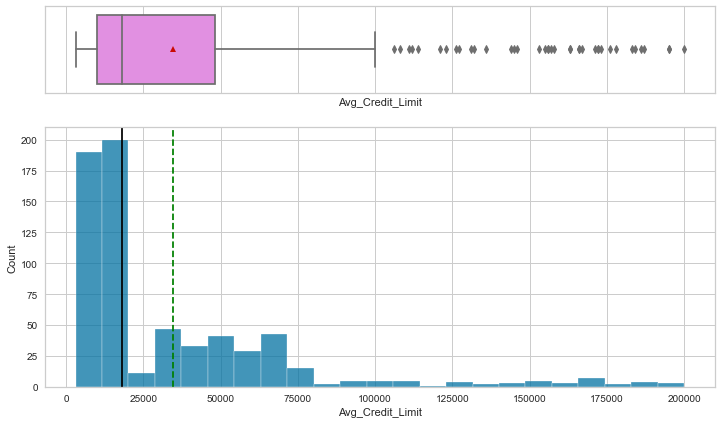

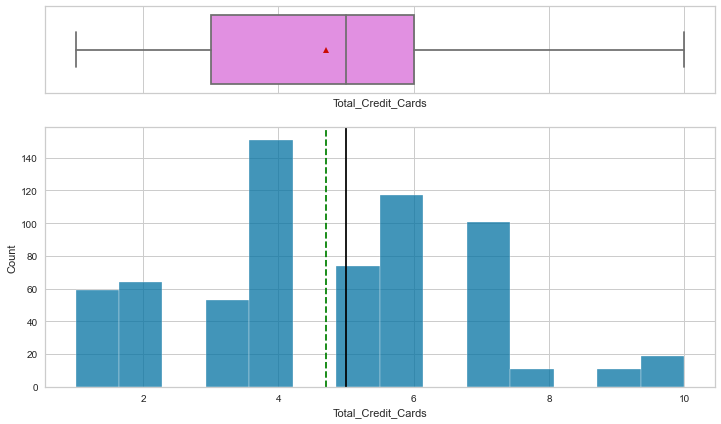

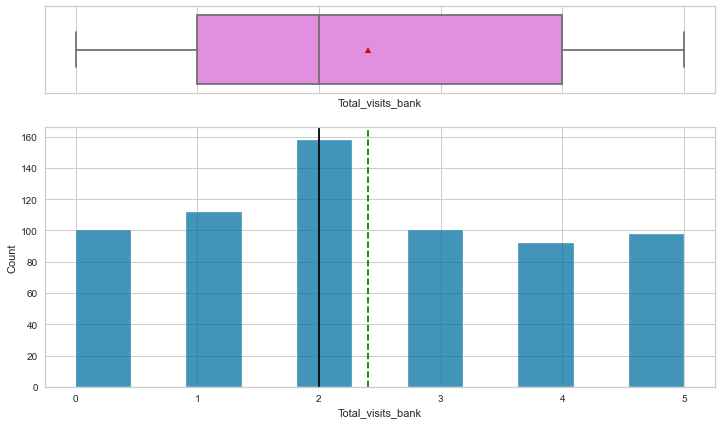

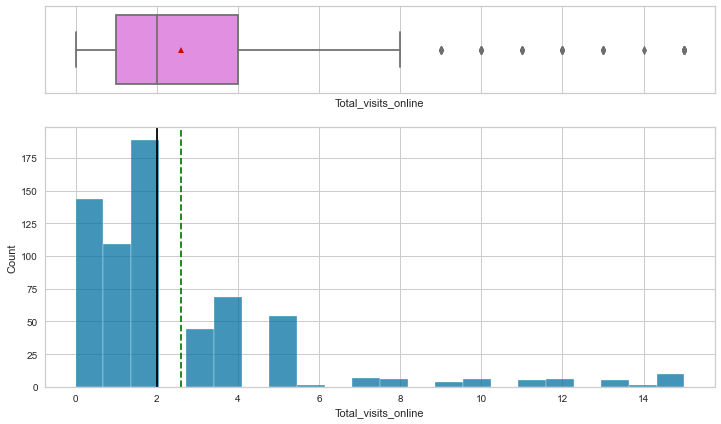

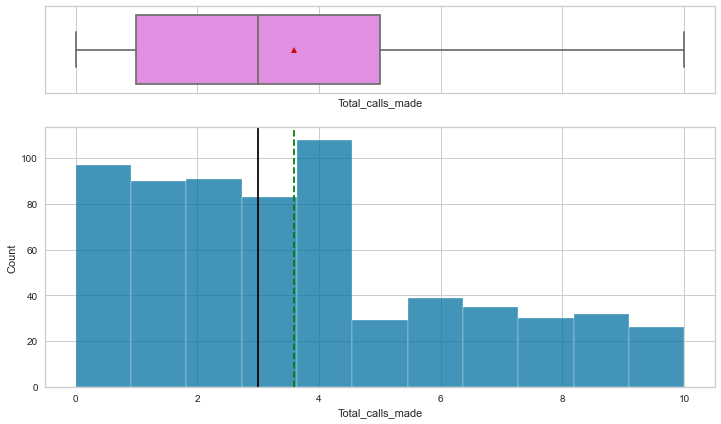

<IPython.core.display.Javascript object>

In [22]:
# selecting numerical columns
num_col = df.select_dtypes(include=np.number).columns.tolist()

for item in num_col:
    histogram_boxplot(df, item)

Observations:
* Avg credit limit and total visits online are both heavily right skewed and have outliers.
* These outliers could affect K-means clustering as it is sensitive to outliers.

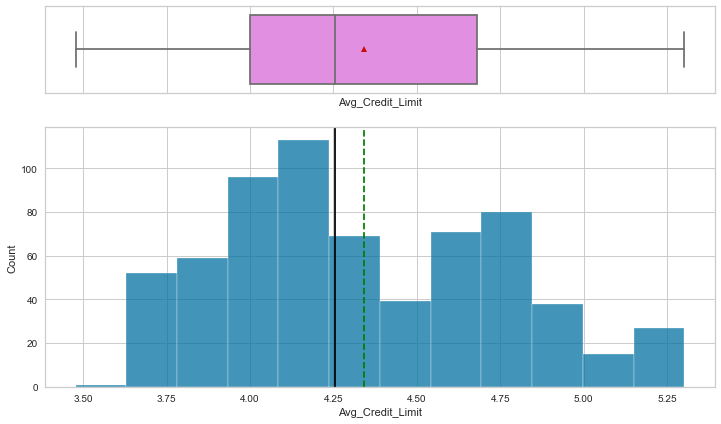

<IPython.core.display.Javascript object>

In [23]:
# Performing the log10
df["Avg_Credit_Limit"] = np.log10(df["Avg_Credit_Limit"])
# Making a new histogram boxplot based on the log
histogram_boxplot(df, "Avg_Credit_Limit")

Log10ing Avg_Credit_Limit fixed the outlier problem. Now it is much more normally distributed with little skew and no outliers.

Now to try a similar treatment for total online visits.

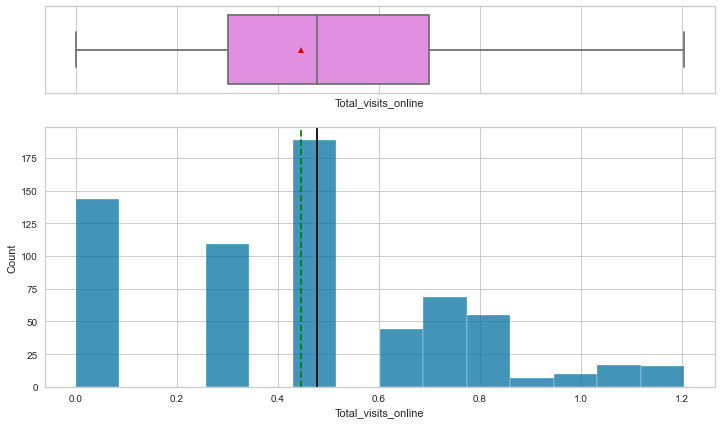

<IPython.core.display.Javascript object>

In [24]:
# Performing the log10
df["Total_visits_online"] = np.log10(df["Total_visits_online"] + 1)
# Making a new histogram boxplot based on the log
histogram_boxplot(df, "Total_visits_online")

I had to +1 so log could work as there were plenty of 0s.

It eliminated the outliers and made it much more normally distributed.

## Bivariate Relationships

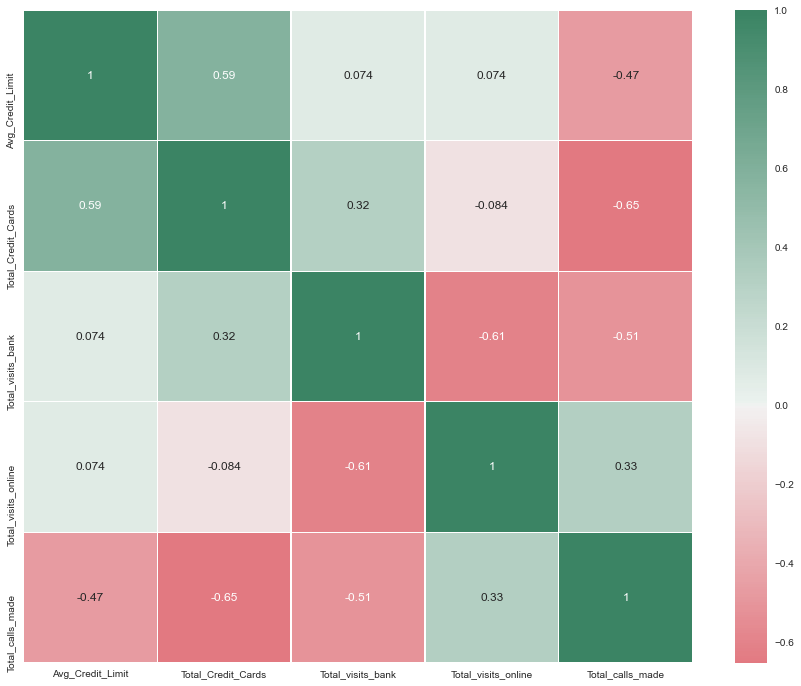

<IPython.core.display.Javascript object>

In [25]:
# Making a correlation plot
plt.figure(figsize=(15, 12))

cmap = sns.diverging_palette(10, 150, as_cmap=True)

ax = sns.heatmap(
    data=df.corr(), annot=True, linewidths=0.1, center=0, cbar=True, cmap=cmap
)
plt.show()

Observations
* There are a lot of moderate correlations, both negative and positive.
* None of the variables are independent.
* A PCA should be effective in reducing dimensions

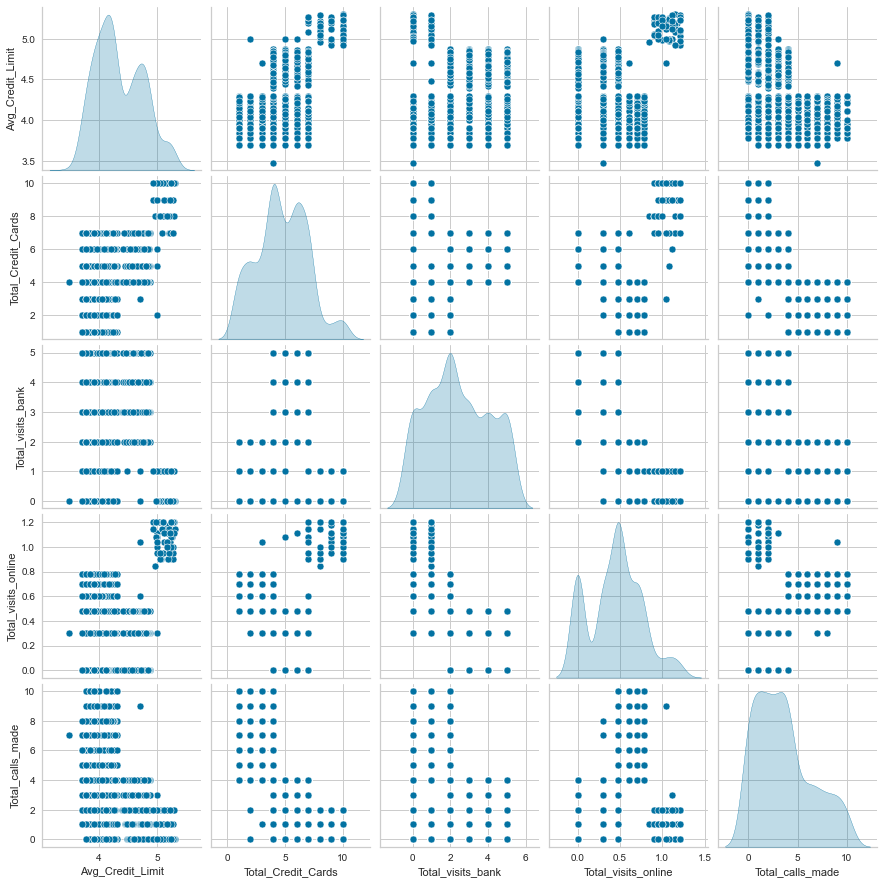

<IPython.core.display.Javascript object>

In [26]:
# Visualizing the interactions between variables via pairplot
sns.pairplot(data=df, diag_kind="kde")
plt.show()

That's some weird clusters in the upper corner of total visits online.

As noted in the correlation matrix, I see a lot of relationships among the variables. I think this means that a principle component analysis will do well.

Observations and expectations:
* Because there is a big clump in the upper corner of online visits and credit limit, I expect these two factors to be clustered together.
* The same should probably happen for number of credit cards and visits online
* There is a big gap for total calls made and credit cards and visits to the bank, the upper right is empty for both interactions. I hypothesize that this means people with lots of credit cards or bank visits will tend to not make very many calls. This is supported by the negative correlations.
* A clump exists with total visits online and calls made, implying if there are lots of visits online they are less likely to make calls.
* Based on the number of peaks in some of the kge graphs, I would estimate between two to five clusters is the appropriate number. Credit limit has two, credit cards has four-ish, bank visits has three-ish, visits online has three, and calls-made has two.

# Data Preprocessing

In [27]:
# scaling the dataset before clustering
scaler = StandardScaler()
scaled = df[num_col].copy()
df_scaled = scaler.fit_transform(scaled)

<IPython.core.display.Javascript object>

In [28]:
# Turning the scaled df into something we can read by adding column names
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = df.columns
df_scaled

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.630478,-1.249225,-0.860451,-0.468807,-1.251537
1,0.885387,-0.787585,-1.473731,1.937062,1.891859
2,0.885387,1.058973,-0.860451,0.509415,0.145528
3,0.336281,0.135694,-0.860451,-0.468807,0.145528
4,1.630478,0.597334,-1.473731,2.172822,-0.203739
...,...,...,...,...,...
655,1.619674,2.443892,-0.860451,1.937062,-1.251537
656,1.443058,2.443892,-0.860451,2.277409,-0.553005
657,2.029885,1.520613,-0.860451,1.802554,-0.902271
658,2.213443,2.443892,-0.860451,2.465858,-1.251537


<IPython.core.display.Javascript object>

In [29]:
# Checking to see if everything scaled properly.
df_scaled.describe().round(1)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
count,660.0,660.0,660.0,660.0,660.0
mean,-0.0,-0.0,0.0,0.0,-0.0
std,1.0,1.0,1.0,1.0,1.0
min,-2.1,-1.7,-1.5,-1.4,-1.3
25%,-0.8,-0.8,-0.9,-0.5,-0.9
50%,-0.2,0.1,-0.2,0.1,-0.2
75%,0.8,0.6,1.0,0.8,0.5
max,2.4,2.4,1.6,2.5,2.2


<IPython.core.display.Javascript object>

Everything scaled nicely, all std are 1 and all means are 0.

# K-Means Clustering

For k-means we have one major question to ask: How many clusters is optimal?

To do that, we're going to use an assortment of measures of performance and see where they point us. We'll also get a visual to see if the numbers we're getting make sense. First up is the elbow check.

## Elbow Method

The more clusters we have the less the intra-cluster distances will become. However, we don't want to minimize this number, as that will lead us to each point being its own cluster, which is completely unhelpful.

Instead, we look at the decline and try to get the best "bang for our buck", keeping the clusters low in number while minimizing intra-cluster distances.

In [30]:
# List to store cluster and intra cluster distance

clusters = []
inertia_vals = (
    []
)  # Variance - Intra cluster sum of distance ; within cluster sum of distance

# Since creating one cluster is similar to observing the data as a whole, multiple values of K are utilized to come up with the optimum cluster value
# Note: Cluster number and intra cluster distance is appended for plotting the elbow curve
for k in range(1, 21, 1):

    # train clustering with the specified K
    model = KMeans(n_clusters=k, random_state=1)
    model.fit(df_scaled)

    # append model to cluster list
    clusters.append(model)
    inertia_vals.append(model.inertia_)

<IPython.core.display.Javascript object>

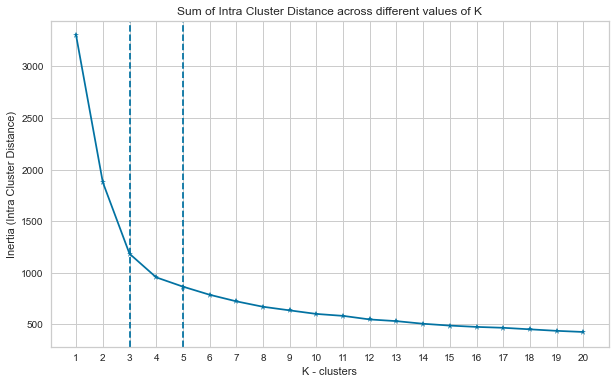

<IPython.core.display.Javascript object>

In [31]:
# plot the inertia vs K values

plt.figure(figsize=(10, 6))
plt.plot(range(1, 21, 1), inertia_vals, marker="*")
plt.title("Sum of Intra Cluster Distance across different values of K")
plt.axvline(3, linestyle="--")
plt.axvline(5, linestyle="--")
plt.xlabel("K - clusters")
plt.ylabel("Inertia (Intra Cluster Distance)")

plt.xticks(range(1, 21, 1))

plt.show()

That elbow graph implies the best number of clusters is probably between 3 and 5. I want to look closer to see the change in distance.

In [32]:
# Finding the difference between each value so we can graph it
abs_diff = []

for i in range(0, len(inertia_vals) - 1):

    diff = round((inertia_vals[i] - inertia_vals[i + 1]) / inertia_vals[i], 2)

    abs_diff.append(diff)

<IPython.core.display.Javascript object>

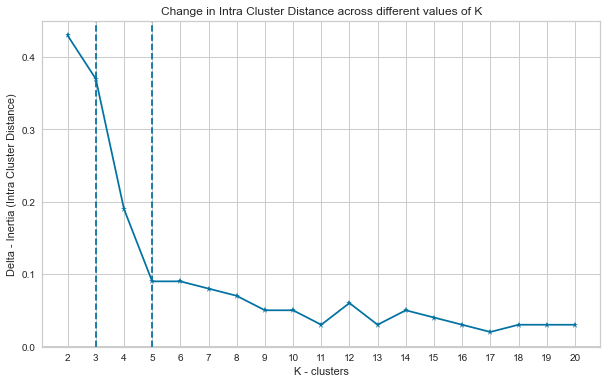

<IPython.core.display.Javascript object>

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(range(2, 21, 1), abs_diff, marker="*")
plt.title("Change in Intra Cluster Distance across different values of K")
plt.xlabel("K - clusters")
plt.ylabel("Delta - Inertia (Intra Cluster Distance)")

plt.xticks(range(2, 21, 1))

plt.axvline(3, linestyle="--")
plt.axvline(5, linestyle="--")

plt.show()

The change from 2 to 3 is enormous, with change dramatically decreasing after 3. 3 is starting to look like an excellent number of clusters. Let's look at the silhouette scores.

### Silhouette Score

The Silhouette Score is one method of measuring how each cluster compares to each other one. Optimally, each member of a cluster should be close to the other members of its cluster and far away from all the members of all the other clusters. The Silhouette Coefficient (or score) gives us a measure for how well we're doing in this regard.


For n_clusters = 2, the silhouette score is 0.4153008591312893)
For n_clusters = 3, the silhouette score is 0.4835620295832657)
For n_clusters = 4, the silhouette score is 0.37635776485414163)
For n_clusters = 5, the silhouette score is 0.35402173445941)
For n_clusters = 6, the silhouette score is 0.2544829368190983)
For n_clusters = 7, the silhouette score is 0.25237623561162004)
For n_clusters = 8, the silhouette score is 0.24650497868184132)
For n_clusters = 9, the silhouette score is 0.25924951641975663)


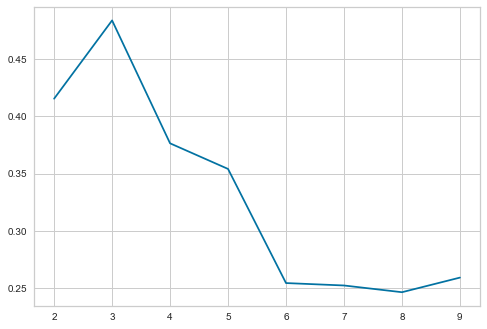

<IPython.core.display.Javascript object>

In [34]:
# Getting the silhouette score for each k and adding it to a list to be printed and graphed
sil_score = []
cluster_list = list(range(2, 10))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((df_scaled))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(df_scaled, preds)
    sil_score.append(score)
    print("For n_clusters = {}, the silhouette score is {})".format(n_clusters, score))

plt.plot(cluster_list, sil_score)
plt.show()

Silhouette score for 3 is much higher than 4 and 5. Everything seems to be pointing to 3 clusters being the best k.

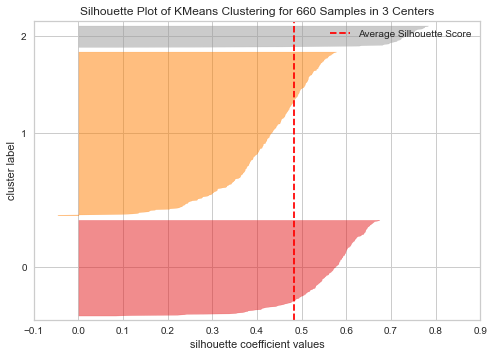

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

<IPython.core.display.Javascript object>

In [35]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(3, random_state=1))
visualizer.fit(df_scaled)
visualizer.show()

As expected, all three clusters have excellent silhouette scores. Two of the clusters are similar size, with one being quite small.

I want to compare it to 5, another option.

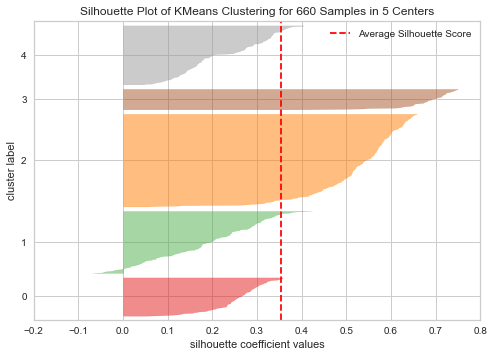

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

<IPython.core.display.Javascript object>

In [36]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(5, random_state=1))
visualizer.fit(df_scaled)
visualizer.show()

Except for one cluster with excellent scores, the others are all quite low and with large spreads.

## Calinski-Harabasz Index for optimal clusters

The Calinski-Harabasz index measures the distance of each point of data to their cluster's center, sums their squares, and then divides it by the distance between cluster centers.

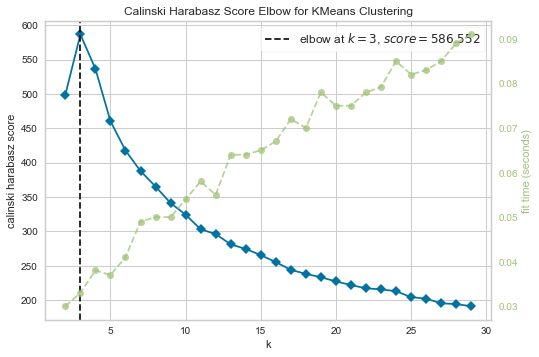

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

<IPython.core.display.Javascript object>

In [37]:
# Calinski Harabasz Score for K means
model = KMeans(random_state=1)
# k is range of number of clusters.
visualizer = KElbowVisualizer(
    model, k=(2, 30), metric="calinski_harabasz", timings=True
)
visualizer.fit(df_scaled)  # Fit the data to the visualizer
visualizer.show()  # Finalize and render the figure

This index is also showing 3 clusters as being the optimal number as the "elbow" is at k = 3.

## Davies-Bouldin Index

Th DB index measures separation and compactness of clusters. For DB, we actually want the lowest score, not the highest.

Text(0.5, 1.0, 'Davies Bouldin score vs. K')

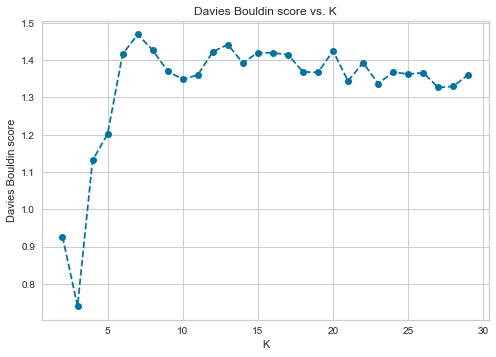

<IPython.core.display.Javascript object>

In [38]:
# Davies Bouldin score for K means


def get_kmeans_score(data, center):
    """
    returns the kmeans score regarding Davies Bouldin for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the Davies Bouldin score for the kmeans model fit to the data
    """
    # instantiate kmeans
    kmeans = KMeans(n_clusters=center, random_state=1)
    # Then fit the model to the data using the fit method
    model = kmeans.fit_predict(df_scaled)

    # Calculate Davies Bouldin score
    score = davies_bouldin_score(df_scaled, model)

    return score


scores = []
centers = list(range(2, 30))
for center in centers:
    scores.append(get_kmeans_score(df_scaled, center))

plt.plot(centers, scores, linestyle="--", marker="o", color="b")
plt.xlabel("K")
plt.ylabel("Davies Bouldin score")
plt.title("Davies Bouldin score vs. K")

In [39]:
scores[1]

0.7399205638839962

<IPython.core.display.Javascript object>

k = 3 has by far the lowest DB score, meaning it has the most distinct and separate clusters.

## Gap Statistic for optimal clusters

The gap statistic is a measure of how the sample compares to a set of data with no obvious clustering. We want the gap statistic to be as far from "no obvious clustering" as possible.

Theoretically speaking, the higher the gap statistic, the better. However, using real world data sometimes leads to poor results with far too many clusters. It has been suggested that, similar to the elbow method, we look at when the rate of increase of the gap statistic begins to slow.

In [40]:
# Gap Statistic for K means
def optimalK(data, nrefs=3, maxClusters=15):
    """
    Calculates KMeans optimal K using Gap Statistic 
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({"clusterCount": [], "gap": []})
    for gap_index, k in enumerate(range(1, maxClusters)):
        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)
        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):

            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)

            # Fit to it
            km = KMeans(k)
            km.fit(randomReference)

            refDisp = km.inertia_
            refDisps[i] = refDisp
        # Fit cluster to original data and create dispersion
        km = KMeans(k, random_state=1)
        km.fit(data)

        origDisp = km.inertia_
        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)
        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap

        resultsdf = resultsdf.append({"clusterCount": k, "gap": gap}, ignore_index=True)
    return (gaps.argmax() + 1, resultsdf)

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Gap Statistic vs. K')

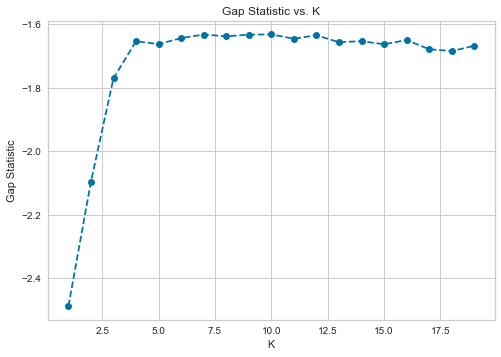

<IPython.core.display.Javascript object>

In [41]:
score_g, df = optimalK(df_scaled, nrefs=3, maxClusters=20)
plt.plot(df["clusterCount"], df["gap"], linestyle="--", marker="o", color="b")
plt.xlabel("K")
plt.ylabel("Gap Statistic")
plt.title("Gap Statistic vs. K")

The gap statistic suggests either 3 or 4 clusters being optimal, which is completely in line with our other findings. So far, 3 still remains in the lead as it has consistently been at or near the top of our evaluation statistics. 4 is also possible. I want more information.

I want to now do a principle component analysis to get a visual on the data and to estimate the best number of clusters.

## Using PCA to examine optimal number of clusters

Principle Component Analysis (PCA) is a way to reduce the number of numerical variables while still explaining a large portion of the variance. PCA works best when there are many factors that are correlated with one another. We saw from the above correlation matrix that this is the case: None of the features being investigated

There are many features involved in our clustering attempts. While computers have no difficulty functioning in high dimensions, we humans need to see things on a 2D or 3D image. PCA can reduce the features to 2 or 3 and then plot them so we can actually visualize the data points. This functions as a good sanity check for our choice of k.

First let's look at how useful our principle components actually are. How representative will our graphs be?

In [42]:
# Principal Component Extraction using sklearn.decomposition package
pca = PCA(n_components=5)
pca.fit_transform(df_scaled)
pc_comps = ["PC1", "PC2", "PC3", "PC4", "PC5"]
prop_var = np.round(pca.explained_variance_ratio_, 2)
std_dev = np.round(np.sqrt(pca.explained_variance_), 2)
cum_var = np.round(np.cumsum(pca.explained_variance_ratio_), 2)
temp = pd.DataFrame(pc_comps, columns=["PCs"])
temp["Proportion Of Variance"] = prop_var
temp["Standard Deviation"] = std_dev
temp["Cumulative Proportion"] = cum_var
temp

,PCs,Proportion Of Variance,Standard Deviation,Cumulative Proportion
0,PC1,0.50,1.58,0.50
1,PC2,0.29,1.20,0.79
2,PC3,0.09,0.66,0.87
3,PC4,0.07,0.58,0.94
4,PC5,0.06,0.55,1.00


<IPython.core.display.Javascript object>

As we can see from extracting the PCs, we see that there is a major diminishing of returns for adding PCs after 2, with PC3 only explaining an additional 10% of the variance of the data. Two PCs explain 78% of the variance of the data. This means our 2D graphs will be fairly accurate, which is good because they are the easiest to read.

Next, we'll visualize the clusters based on intercluster distance. Basically, it shows how far apart the clusters are relative to one another. The size of the circle is the number of data points in that cluster, not the spread of the cluster.

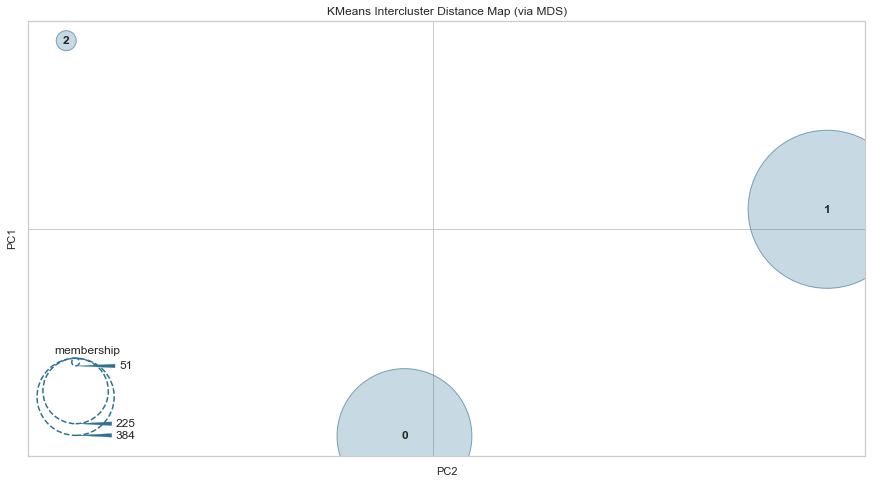

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

<IPython.core.display.Javascript object>

In [43]:
plt.figure(figsize=(15, 8))

# Instantiate the clustering model and visualizer
model = KMeans(3, random_state=1)

visualizer = InterclusterDistance(model, random_state=1)

visualizer.fit(df_scaled)
# Fit the data to the visualizer

visualizer.show()
# Finalize and render the figure

With 3 clusters there is a great separation between the groups with little chance of overlap.  Let's go ahead and check 4 clusters too.

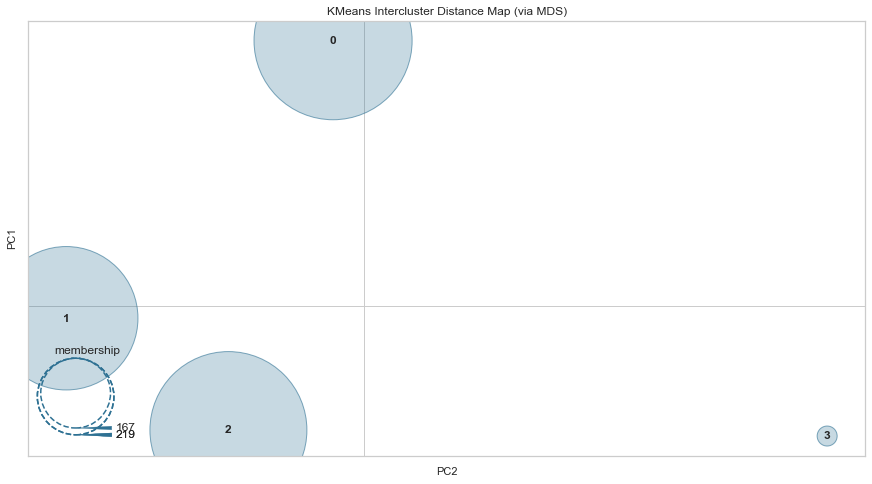

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

<IPython.core.display.Javascript object>

In [44]:
plt.figure(figsize=(15, 8))

# Instantiate the clustering model and visualizer
model = KMeans(4, random_state=1)

visualizer = InterclusterDistance(model, random_state=1)

visualizer.fit(df_scaled)
# Fit the data to the visualizer

visualizer.show()
# Finalize and render the figure

With 4 clusters, three of the clusters move much closer together but are still reasonably separated. Let's check out 5 as well.

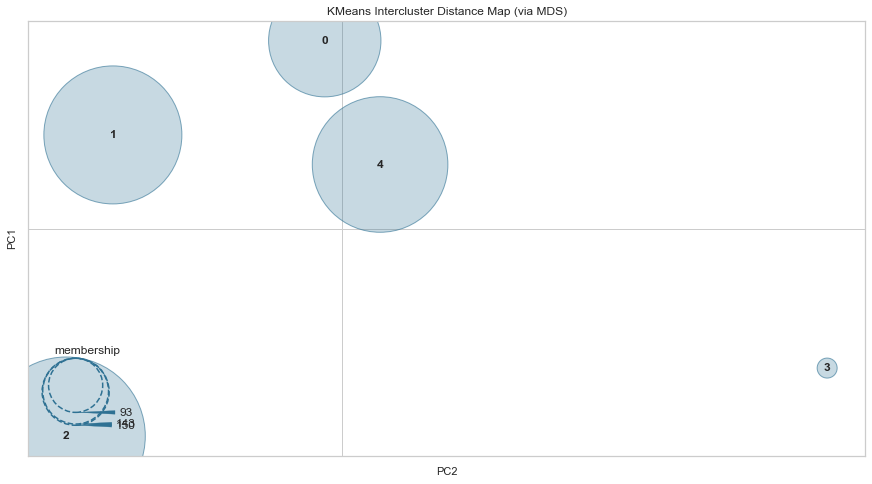

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

<IPython.core.display.Javascript object>

In [45]:
plt.figure(figsize=(15, 8))

# Instantiate the clustering model and visualizer
model = KMeans(5, random_state=1)

visualizer = InterclusterDistance(model, random_state=1)

visualizer.fit(df_scaled)
# Fit the data to the visualizer

visualizer.show()
# Finalize and render the figure

With 5 clusters, three of the clusters start to get fairly close to one another. If we want to see the degree these clusters overlap, we'll have to use scatterplots.

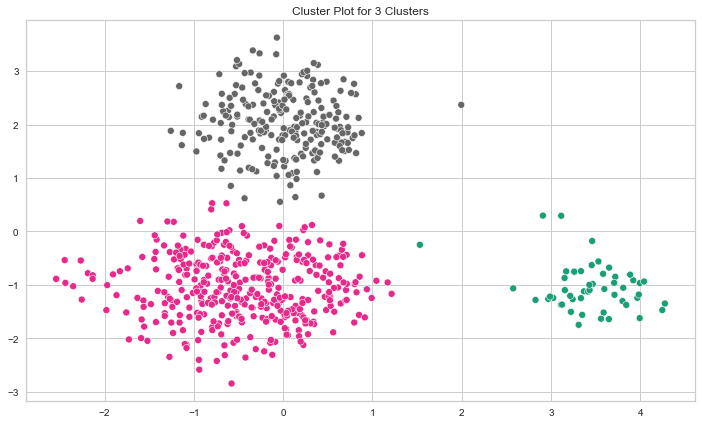

<IPython.core.display.Javascript object>

In [46]:
# Making a cluster plot with two PCs based on our scaled dataset.
pca_2 = PCA(2)
plot_columns = pca_2.fit_transform(df_scaled)
plt.figure(figsize=(12, 7))
sns.scatterplot(
    x=plot_columns[:, 1],
    y=plot_columns[:, 0],
    hue=KMeans(n_clusters=3, random_state=1)
    .fit(df_scaled)
    .labels_,  # We'll start with 3 clusters
    palette="Dark2_r",
    legend=False,
)
plt.title("Cluster Plot for 3 Clusters")
plt.show()

Visually, those are three pretty distinct clusters. Only two data points are really vague, hovering between the two large clusters and the smaller cluster.

Because the distance graphs and elbow analysis implied 4 and 5 clusters could work, let's look at their scatterplots too.

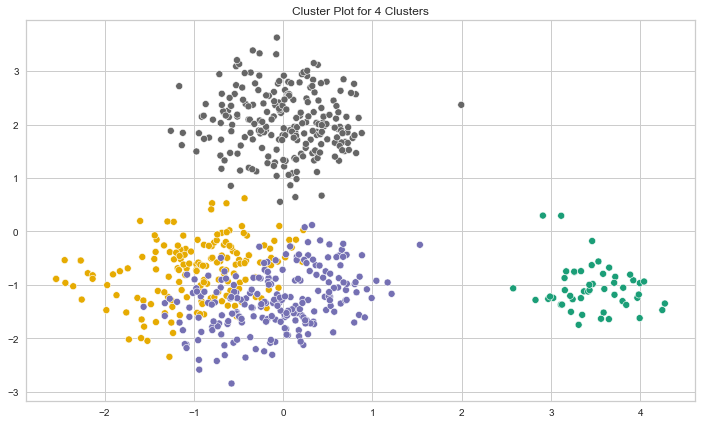

<IPython.core.display.Javascript object>

In [47]:
# Making a cluster plot with two PCs based on our scaled dataset.
pca_2 = PCA(2)
plot_columns = pca_2.fit_transform(df_scaled)
plt.figure(figsize=(12, 7))
sns.scatterplot(
    x=plot_columns[:, 1],
    y=plot_columns[:, 0],
    hue=KMeans(n_clusters=4, random_state=1).fit(df_scaled).labels_,
    palette="Dark2_r",
    legend=False,
)
plt.title("Cluster Plot for 4 Clusters")
plt.show()

The large cluster on the bottom has been split in two, making it less distinct (and hence, less useful) as a cluster. Let's look at 5 as well.

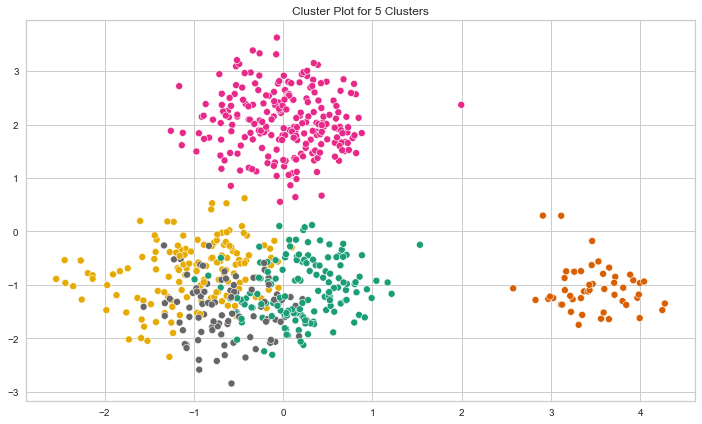

<IPython.core.display.Javascript object>

In [48]:
pca_2 = PCA(2)
plot_columns = pca_2.fit_transform(df_scaled)
plt.figure(figsize=(12, 7))
sns.scatterplot(
    x=plot_columns[:, 1],
    y=plot_columns[:, 0],
    hue=KMeans(n_clusters=5, random_state=1).fit(df_scaled).labels_,
    palette="Dark2_r",
    legend=False,
)
plt.title("Cluster Plot for 5 Clusters")
plt.show()

The bottom cluster was further divided, making it even more of a mess.

The conclusion is fairly obvious: 3 clusters seems to be the optimal number.

However, I want to explore one last option using PCA. The third principle component explained 10% of the variance, which is still somewhat substantial. Perhaps a 3D plot would be even more explanatory. We'll start with 4 and 5 then do 3 clusters.

In [49]:
"""
This defined function takes the dataframe you want to work with and the number of clusters you're
testing, and then feeds them in to k-means clusterer. It then graphs the results on a 3d graph.

"""


def Three_D_Model(df, clusters):
    # Set the value of k
    kmeans = KMeans(n_clusters=clusters, random_state=1)

    kmeans.fit(df)

    df_label = pd.DataFrame(kmeans.labels_, columns=list(["labels"]))

    # Applying the labels to the scaled dataframe so we can do a PCA 3 graph
    df_label["labels"] = df_label["labels"].astype("category")

    # create figure
    my_dpi = 96
    plt.figure(figsize=(480 / my_dpi, 480 / my_dpi), dpi=my_dpi)

    # get codes for the labels so we can color them differently
    my_color = df_label["labels"].cat.codes

    # Run The PCA
    pca = PCA(n_components=3)
    pca.fit(df)
    # Store results of PCA in a data frame
    result = pd.DataFrame(
        pca.transform(df), columns=["PCA%i" % i for i in range(3)], index=df.index,
    )

    # Plot initialisation
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(
        result["PCA0"], result["PCA1"], result["PCA2"], c=my_color, cmap="Set2_r", s=60,
    )

    # make simple, bare axis lines through space:
    xAxisLine = ((min(result["PCA0"]), max(result["PCA0"])), (0, 0), (0, 0))
    ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], "r")
    yAxisLine = ((0, 0), (min(result["PCA1"]), max(result["PCA1"])), (0, 0))
    ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], "r")
    zAxisLine = ((0, 0), (0, 0), (min(result["PCA2"]), max(result["PCA2"])))
    ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], "r")

    # label the axes
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    ax.set_title("3D PCA on the data set")
    plt.show()

<IPython.core.display.Javascript object>

<Figure size 480x480 with 0 Axes>

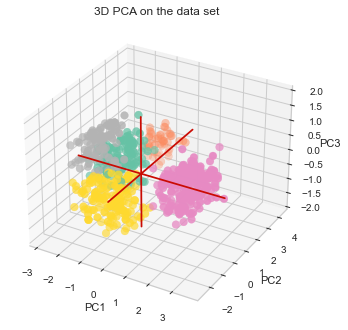

<IPython.core.display.Javascript object>

In [50]:
Three_D_Model(df_scaled, 5)

The colors are the same as the 2D graph.

3D graphs are always harder to understand than 2D ones. However, we can see a general layout almost identical to the 2D counterpart: Two large blobs with a third off to the side.

It's kind of hard to see, but the orange dots are actually disconnected from the green. There isn't overlap there so much as distance that is hard to visualize because the orange blob is behind the green one.

Let's try 4.

<Figure size 480x480 with 0 Axes>

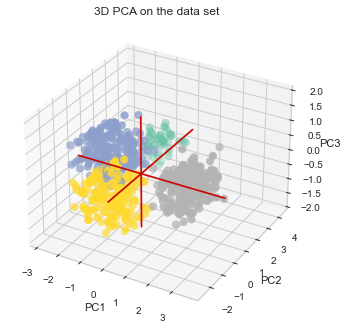

<IPython.core.display.Javascript object>

In [51]:
Three_D_Model(df_scaled, 4)

Again we see quite a bit of overlap between yellow and indigo. Let's try the 3 clusters.

<Figure size 480x480 with 0 Axes>

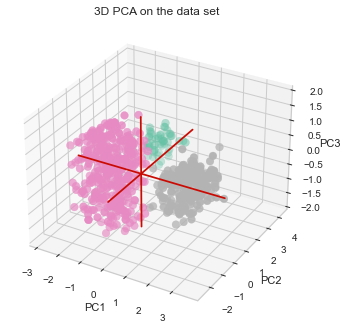

<IPython.core.display.Javascript object>

In [52]:
Three_D_Model(df_scaled, 3)

This seems more appropriate to me, there is almost no overlap between the clusters even if the green blob weren't behind the pink blob. Thus, adding an additional 10% of variance explained in the graphs does not change the conclusion: 3 clusters is quite solid, with little to no overlap between the clusters.

We will consider k=3 to be the optimal number of clusters. This is because:
1. The elbow at k=3 was steepest with a huge drop in inertia
2. The highest silhouette score was for k=3 by far
3. The gap statistic implies k=3 is best
4. The DB score also showed k=3 as best
5. The Calinski-Harabasz Index highlighted k=3 as best
6. The cluster distribution for k=3 was subjectively very distinct, especially compared to k=5, which was another consideration.
7. The PCA graphics all show three distinct groups with little overlap

### Cluster Comparisons

In [53]:
# Adding the labels to the original dataframe so we can get accurate profiles for each cluster
# Running the Kmeans with k=3
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit(df_scaled)

# Creating a label dataframe to add on to the original data
df_labels = pd.DataFrame(kmeans.labels_, columns=list(["k_labels"]))

df_labels["k_labels"] = df_labels["k_labels"].astype("category")

# Joining the label dataframe with the data frame.
df_labeled = data.join(df_labels)
df_labeled.drop("Customer Key", axis=1, inplace=True)
df_labeled.drop("Sl_No", axis=1, inplace=True)
df_labeled["k_labels"].value_counts()

1    384
0    225
2     51
Name: k_labels, dtype: int64

<IPython.core.display.Javascript object>

In [54]:
# Sanity check to make sure it all went well.
df_labeled

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,k_labels
0,100000,2,1,1,0,1
1,50000,3,0,10,9,0
2,50000,7,1,3,4,2
3,30000,5,1,1,4,1
4,100000,6,0,12,3,2
...,...,...,...,...,...,...
655,99000,10,1,10,0,2
656,84000,10,1,13,2,2
657,145000,8,1,9,1,2
658,172000,10,1,15,0,2


<IPython.core.display.Javascript object>

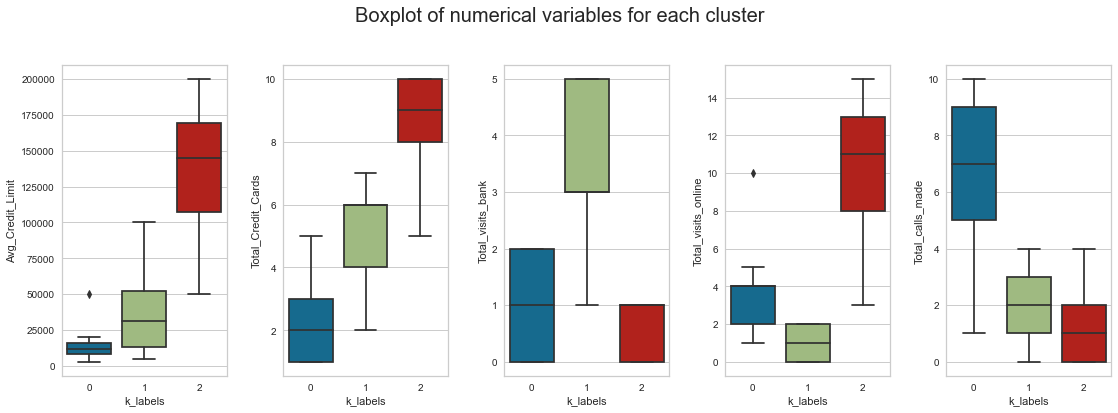

<IPython.core.display.Javascript object>

In [55]:
# Making boxplots for each cluster across each column so we can differentiate between them.
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of numerical variables for each cluster", fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(
        ax=axes[ii], y=df_labeled[num_col[counter]], x=df_labeled["k_labels"],
    )
    counter = counter + 1

fig.tight_layout(pad=2.0)

From here we see that the three groups are starting to come together. It seems like

Group 0: Vocalizers
* Second largest group
* Very low credit limit
* Low number of credit cards
* Almost never visits the bank or uses online services
* Huge number of calls made


Group 1: In-Person
* Largest group
* Mid number of credit cards
* Visits the bank often
* Almost no online usage
* Calls rarely

Group 2: Online
* Smallest group, and by a large margine
* Huge credit limit
* Lots of credit cards
* Almost never visits the bank
* Banks online extensively
* Almost never calls

These three groups are defined most sharply by how they interact with the bank, as there is almost no overlap when it comes to their primary interaction variable. For whatever reason, customers seem to overwhelmingly prefer one method of contacting the bank.

Of note is that the high credit-limit customers are online bankers. Having a high credit rating usually indicates a high credit rating, good standing with the bank, and a long-term relationship. It also implies the user is wealthier, as income and credit score are moderately correlated. https://www.federalreserve.gov/econres/notes/feds-notes/are-income-and-credit-scores-highly-correlated-20180813.htm



# Hierarchical Clustering

Hierarchical clustering has a wide variety of methods. We want to try these as well because k-means does not always have the best performance.

Although the PCA analysis strongly implied three clusters to be optimal, it will also be interesting to see if the dendrograms imply four or five would be better.

Now we'll look at the dendrograms made by each method.

## Distance Measures

For each method there are a variety of distance measures (except for ward). I can see which performs better by checking out their cophenetic correlations.

In [56]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:

    print("-" * 50)

    for lm in linkage_methods:

        # -------------------Default is Euclidean Distance for Linkage

        Z = linkage(df_scaled, metric=dm, method=lm)

        c, coph_dists = cophenet(Z, pdist(df_scaled))

        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, round(c, 3)
            )
        )

        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

--------------------------------------------------
Cophenetic correlation for Euclidean distance and single linkage is 0.618.
Cophenetic correlation for Euclidean distance and complete linkage is 0.81.
Cophenetic correlation for Euclidean distance and average linkage is 0.849.
--------------------------------------------------
Cophenetic correlation for Chebyshev distance and single linkage is 0.498.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.782.
Cophenetic correlation for Chebyshev distance and average linkage is 0.847.
--------------------------------------------------
Cophenetic correlation for Mahalanobis distance and single linkage is 0.568.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.386.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.727.
--------------------------------------------------
Cophenetic correlation for Cityblock distance and single linkage is 0.57.
Cophenetic correlation for Citybl

<IPython.core.display.Javascript object>

Ideally the cophenetic correlation is high, but it is not the only measure. We'll want to look more deeply into each of the methods. However, it is fairly safe to say that the distance measure with the highest cophenetic correlation is probably the best one to use with that method.

Of course in this case Euclidean distance is the best for all of the methods, but it was worth checking.

Note: Ward only accepts Euclidean, so we'll use that one for ward.

## Average Linkage

In [57]:
# Creating linkages so that we can populate the dendrogram
Z = linkage(df_scaled, metric="euclidean", method="average")
c, coph_dists = cophenet(Z, pdist(df_scaled))

<IPython.core.display.Javascript object>

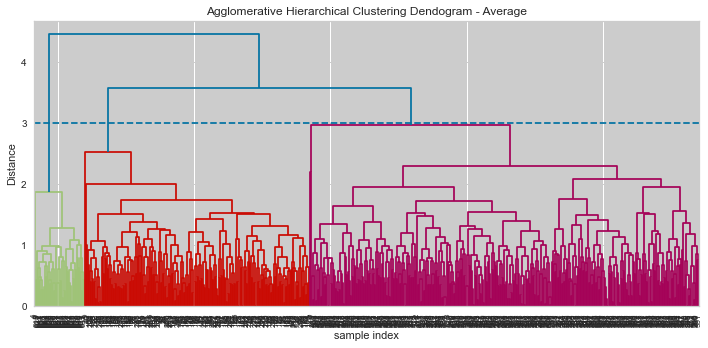

<IPython.core.display.Javascript object>

In [58]:
# plotting the dendrogram.
plt.figure(figsize=(10, 5))
plt.title("Agglomerative Hierarchical Clustering Dendogram - Average")
plt.xlabel("sample index")
plt.ylabel("Distance")
dendrogram(Z, leaf_rotation=90.0, color_threshold=3, leaf_font_size=8.0)
# Threshold is set at 3 because it cuts the longest lines.
plt.tight_layout()
plt.axhline(y=3, linestyle="--")

The dendrogram implies 3 clusters are optimal because the height of the clusters increases substantially at the 3 threshold.

If we went much lower than that, it would go to 4 clusters, with a tiny number of values in one cluster: This is not an optimal outcome. I think it better to put those outlying data points in the larger cluster.

In [59]:
c_average = c  # Saving for later comparisons
# displaying the cophnetic correlation
c

0.8492731094268281

<IPython.core.display.Javascript object>

The correlation is fairly high (the closer to 1 the better), meaning the dendrogram represents the data trends fairly well.

### Silhouette Score

For n_clusters = 2, the silhouette score is 0.41556083986817255)
For n_clusters = 3, the silhouette score is 0.4839471543806833)
For n_clusters = 4, the silhouette score is 0.39193287371549035)
For n_clusters = 5, the silhouette score is 0.3400343446819413)
For n_clusters = 6, the silhouette score is 0.2918107157564934)
For n_clusters = 7, the silhouette score is 0.25649440387065525)
For n_clusters = 8, the silhouette score is 0.24817327028577013)
For n_clusters = 9, the silhouette score is 0.20860175993367902)


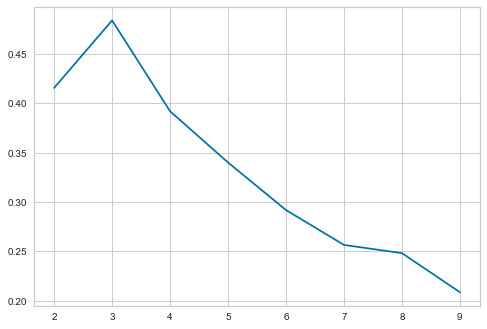

<IPython.core.display.Javascript object>

In [60]:
# Getting the silhouette scores to confirm my suspicions on the number of clusters
avg_sil_score = []
cluster_list = list(range(2, 10))
for n_clusters in cluster_list:
    clusterer = AgglomerativeClustering(
        n_clusters=n_clusters, affinity="euclidean", linkage="average"
    )
    preds = clusterer.fit_predict((df_scaled))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(df_scaled, preds)
    avg_sil_score.append(score)
    print("For n_clusters = {}, the silhouette score is {})".format(n_clusters, score))

plt.plot(cluster_list, avg_sil_score)
plt.show()

The silhouette score is highest for 3 clusters, again implying this is the optimal number of clusters.

I want one more way to compare the clusters. I'm going to look at Davies Bouldin scores, similarly to how I did with k-means.

### Davies Bouldin Score

In [61]:
# I am making a Davies Bouldin score for hierarchical models
# First, I have to modify the function to work for hierarchical clustering.


def get_Hmeans_score(
    data, distance, link, center
):  # I made it so we can specify linkage and distance
    """
    returns the  score regarding Davies Bouldin for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        distance - the distance for AgglomerativeClustering
        link - the linkage method for AgglomerativeClustering
        center - the number of clusters you want (the k value)
    OUTPUT:
        score - the Davies Bouldin score for the kmeans model fit to the data
    """
    # instantiate kmeans
    hmeans = AgglomerativeClustering(n_clusters=center, affinity=distance, linkage=link)
    # Then fit the model to the data using the fit method
    model = hmeans.fit_predict(df_scaled)

    # Calculate Davies Bouldin score
    score = davies_bouldin_score(df_scaled, model)

    return score

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Davies Bouldin score vs. K')

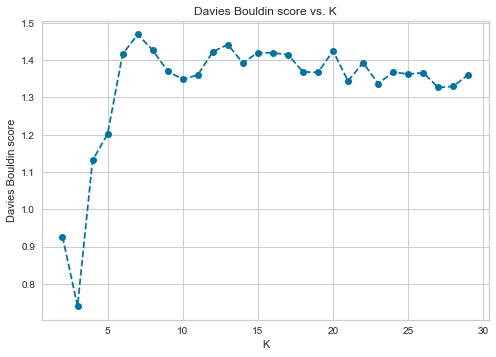

<IPython.core.display.Javascript object>

In [62]:
centers = list(range(2, 30))
avg_scores = []

for center in centers:
    avg_scores.append(get_Hmeans_score(df_scaled, "euclidean", "average", center))

plt.plot(centers, scores, linestyle="--", marker="o", color="b")
plt.xlabel("K")
plt.ylabel("Davies Bouldin score")
plt.title("Davies Bouldin score vs. K")

In [63]:
# Getting the score for 3 clusters
avg_scores[1]

0.736113716356355

<IPython.core.display.Javascript object>

The DB score is lowest for 3 clusters. A lower score is better, this implies 3 is the superior choice for number of clusters. We'll proceed with this number.

### Cluster Comparisons

In [64]:
# Modeling with 3 clusters
model = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="average")
model.fit(df_scaled)

AgglomerativeClustering(linkage='average', n_clusters=3)

<IPython.core.display.Javascript object>

In [65]:
# Labeling the data according to the method
df_labeled["Avg_labels"] = model.labels_

<IPython.core.display.Javascript object>

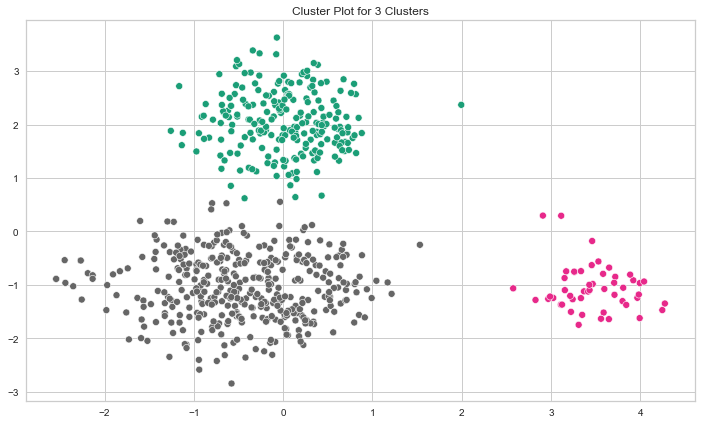

<IPython.core.display.Javascript object>

In [66]:
# Showing a PCA scatterplot of this method to make it comparable to other methods
pca_2 = PCA(2)
plot_columns = pca_2.fit_transform(df_scaled)
plt.figure(figsize=(12, 7))
sns.scatterplot(
    x=plot_columns[:, 1],
    y=plot_columns[:, 0],
    hue=AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="average")
    .fit(df_scaled)
    .labels_,
    palette="Dark2_r",
    legend=False,
)
plt.title("Cluster Plot for 3 Clusters")
plt.show()

The main difference between this method and k-means is one of the floating data points between the left two blobs and the rightmost blob is categorized differently. K-means clustered the lower floater into the rightmost blob, whereas hierarchical average linkage put it in with the lower left blob.

Further, a few of the edge cases between the top and bottom left blobs flipped. In my mind, it made the barriers less distinct.

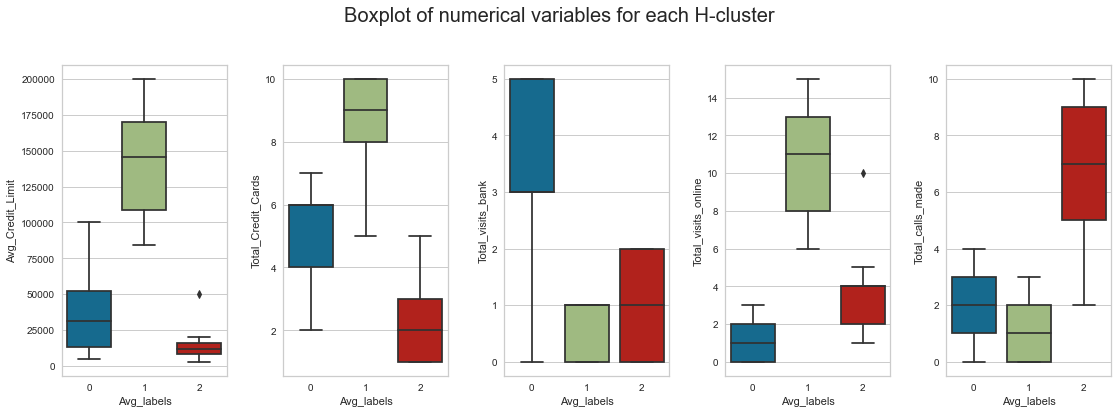

<IPython.core.display.Javascript object>

In [67]:
# Displaying each column as a boxplot to show the differences between each cluster
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of numerical variables for each H-cluster", fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(
        ax=axes[ii], y=df_labeled[num_col[counter]], x=df_labeled["Avg_labels"],
    )
    counter = counter + 1

fig.tight_layout(pad=2.0)

In [68]:
# Seeing how many customers were grouped into each cluster
df_labeled["Avg_labels"].value_counts()

0    386
2    224
1     50
Name: Avg_labels, dtype: int64

<IPython.core.display.Javascript object>

In [69]:
# I want to see the means of each of the groups clearly
h_clusters = df_labeled.groupby(["Avg_labels"])

<IPython.core.display.Javascript object>

In [70]:
h_clusters.mean()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Avg_labels,,,,,
0,33803.108808,5.510363,3.484456,0.979275,1.992228
1,141040.000000,8.740000,0.600000,10.900000,1.080000
2,12138.392857,2.419643,0.941964,3.558036,6.883929


<IPython.core.display.Javascript object>

As we can see from the boxplots and means for each group, this hierarchical method has separated the data into almost identical clusters as the k-means algorithm did.

Again, the most distinct and defining feature of the customer groups are which method they use to contact the bank: online, in-person, or by phone.

Even the number of people in each group is almost identical.

Overall, the trends are very similar to K-Means clustering.

In [71]:
# Finding the standard deviation just for reference.
h_clusters.std()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Avg_labels,,,,,
0,22148.086973,1.146942,1.146884,0.855592,1.427901
1,34457.877272,1.274715,0.494872,2.880264,0.876915
2,5256.944935,1.113620,0.804264,1.211391,1.960349


<IPython.core.display.Javascript object>

## Complete Linkage

In [72]:
# Creating linkages so that we can populate the dendrogram
Z = linkage(df_scaled, metric="euclidean", method="complete")
c, coph_dists = cophenet(Z, pdist(df_scaled))

<IPython.core.display.Javascript object>

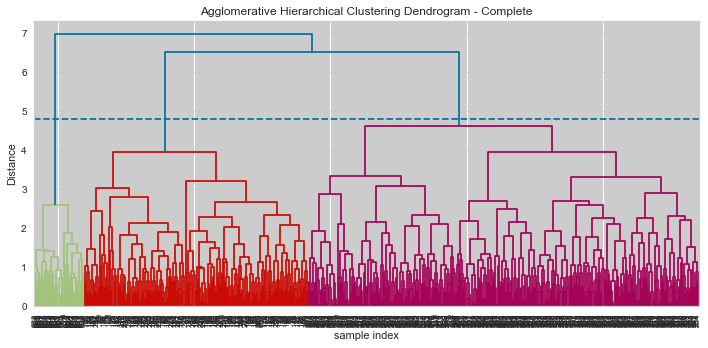

<IPython.core.display.Javascript object>

In [73]:
# Creating a dendrogram for the complete linkage method
plt.figure(figsize=(10, 5))
plt.title("Agglomerative Hierarchical Clustering Dendrogram - Complete")
plt.xlabel("sample index")
plt.ylabel("Distance")
dendrogram(Z, leaf_rotation=90.0, color_threshold=4.8, leaf_font_size=8.0)
plt.tight_layout()
plt.axhline(y=4.8, linestyle="--")

In [74]:
c_complete = c  # Saving for later comparisons
# displaying the cophnetic correlation
c

0.8101657057028301

<IPython.core.display.Javascript object>

Once again the dendrogram suggests three clusters is best. Going to 4 clusters would create a cluster with a tiny number of entries.

The cophenetic correlation score is lower than the previous method.

### Silhouette Scores

For n_clusters = 2, the silhouette score is 0.41556083986817255)
For n_clusters = 3, the silhouette score is 0.48345734468952695)
For n_clusters = 4, the silhouette score is 0.32143478070152975)
For n_clusters = 5, the silhouette score is 0.20676759016016458)
For n_clusters = 6, the silhouette score is 0.2204955989156418)
For n_clusters = 7, the silhouette score is 0.19977470692283825)
For n_clusters = 8, the silhouette score is 0.211279014985825)
For n_clusters = 9, the silhouette score is 0.208936924424156)


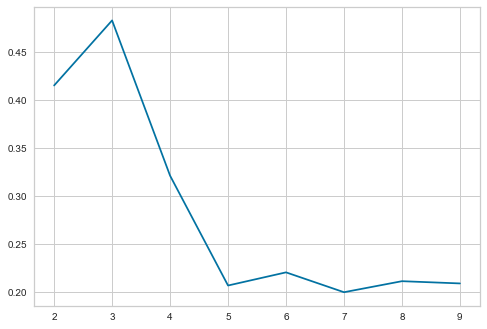

<IPython.core.display.Javascript object>

In [75]:
# Getting the silhouette scores to confirm my suspicions on the number of clusters
complete_sil_score = []
cluster_list = list(range(2, 10))
for n_clusters in cluster_list:
    clusterer = AgglomerativeClustering(
        n_clusters=n_clusters, affinity="euclidean", linkage="complete"
    )
    preds = clusterer.fit_predict((df_scaled))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(df_scaled, preds)
    complete_sil_score.append(score)
    print("For n_clusters = {}, the silhouette score is {})".format(n_clusters, score))

plt.plot(cluster_list, complete_sil_score)
plt.show()

Once again three clusters stands out as the optimal number of clusters. Let's check the DB score too.

### Davies Bouldin Score

Text(0.5, 1.0, 'Davies Bouldin score vs. K')

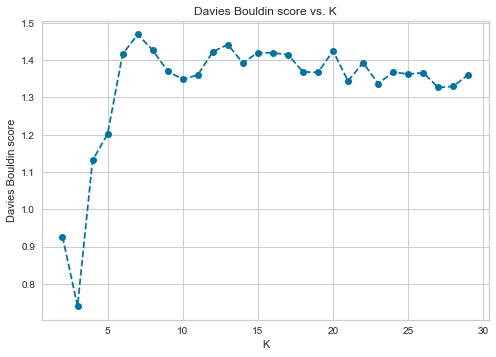

<IPython.core.display.Javascript object>

In [76]:
com_scores = []

for center in centers:
    com_scores.append(get_Hmeans_score(df_scaled, "euclidean", "complete", center))

plt.plot(centers, scores, linestyle="--", marker="o", color="b")
plt.xlabel("K")
plt.ylabel("Davies Bouldin score")
plt.title("Davies Bouldin score vs. K")

In [77]:
com_scores[1]

0.7360876360806129

<IPython.core.display.Javascript object>

The DB score of .736 is lowest at 3 clusters. A lower score is better, this implies 3 is the superior choice for number of clusters. We'll proceed with this number.

### Cluster Comparisons

In [78]:
# Creating the model for this method using 3 clusters to label the data
model = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="complete")
model.fit(df_scaled)

AgglomerativeClustering(linkage='complete', n_clusters=3)

<IPython.core.display.Javascript object>

In [79]:
# labeling the data
df_labeled["H-labels_complete"] = model.labels_

<IPython.core.display.Javascript object>

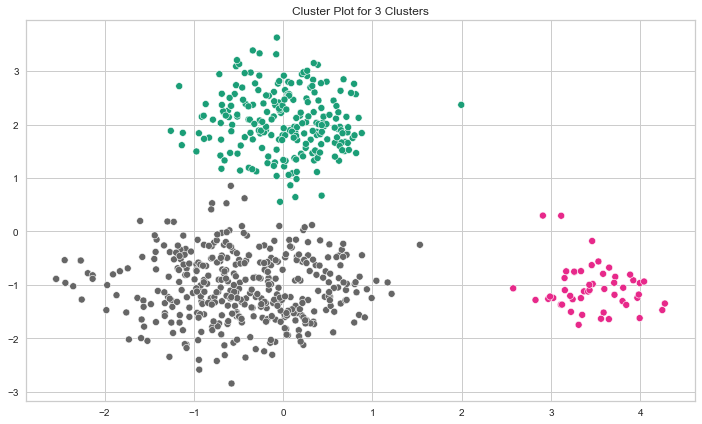

<IPython.core.display.Javascript object>

In [80]:
# Showing a PCA scatterplot of this method to make it comparable to other methods
pca_2 = PCA(2)
plot_columns = pca_2.fit_transform(df_scaled)
plt.figure(figsize=(12, 7))
sns.scatterplot(
    x=plot_columns[:, 1],
    y=plot_columns[:, 0],
    hue=AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="complete")
    .fit(df_scaled)
    .labels_,
    palette="Dark2_r",
    legend=False,
)
plt.title("Cluster Plot for 3 Clusters")
plt.show()

There are a few points between 0 and 1 on the graph that flip depending on the method. I think this caused too much overlap between the lower and upper left blobs.

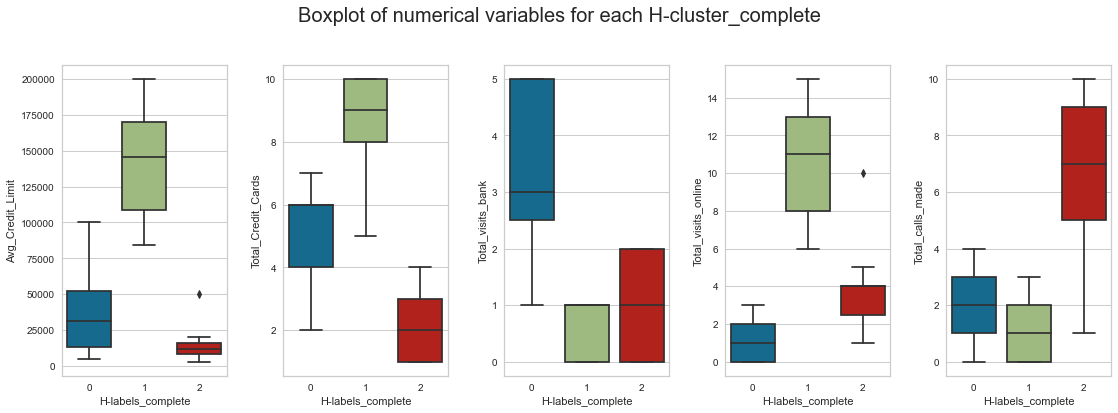

<IPython.core.display.Javascript object>

In [81]:
# Making box plots for each column by cluster so we can compare the clusters
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of numerical variables for each H-cluster_complete", fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(
        ax=axes[ii], y=df_labeled[num_col[counter]], x=df_labeled["H-labels_complete"],
    )
    counter = counter + 1

fig.tight_layout(pad=2.0)

In [82]:
# Finding the number of points categorized into each cluster
df_labeled["H-labels_complete"].value_counts()

0    387
2    223
1     50
Name: H-labels_complete, dtype: int64

<IPython.core.display.Javascript object>

In [83]:
# Getting the means to compare each cluster
h_clusters = df_labeled.groupby(["H-labels_complete"])

<IPython.core.display.Javascript object>

In [84]:
# displaying the mean
h_clusters.mean()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Avg_labels
H-labels_complete,,,,,,
0,33713.178295,5.511628,3.485788,0.984496,2.005168,0.010336
1,141040.000000,8.740000,0.600000,10.900000,1.080000,1.000000
2,12197.309417,2.403587,0.928251,3.560538,6.883408,1.991031


<IPython.core.display.Javascript object>

The trends for the complete linkage method are identical to that of the average method, however the cophenetic correlation is worse, implying it is a less faithful representation of the data.

As a side note, we can kind of see how well the groupings match up. H-labels, from average, have similar means for the groups, meaning the grouping was very similar.

In [85]:
# Finding the standard deviation just for reference.
h_clusters.std()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Avg_labels
H-labels_complete,,,,,,
0,22182.542428,1.141195,1.136616,0.857619,1.432406,0.143591
1,34457.877272,1.274715,0.494872,2.880264,0.876915,0.000000
2,5249.332169,1.098068,0.802171,1.217242,1.985271,0.133930


<IPython.core.display.Javascript object>

The standard deviation being 0 for group 1 for the complete method and for the average method imply that there is no deviation at all: the groups are identical.

## Ward Linkage

In [86]:
# Creating linkages so that we can populate the dendrogram
Z = linkage(df_scaled, metric="euclidean", method="ward")
c, coph_dists = cophenet(Z, pdist(df_scaled))

<IPython.core.display.Javascript object>

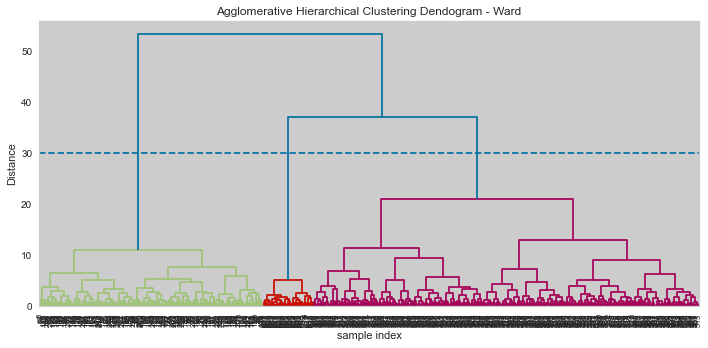

<IPython.core.display.Javascript object>

In [87]:
# Creating a dendrogram for the complete ward method
plt.figure(figsize=(10, 5))
plt.title("Agglomerative Hierarchical Clustering Dendogram - Ward")
plt.xlabel("sample index")
plt.ylabel("Distance")
dendrogram(Z, leaf_rotation=90.0, color_threshold=30, leaf_font_size=8.0)
plt.tight_layout()
plt.axhline(y=30, linestyle="--")

In [88]:
c_ward = c  # Saving for later comparisons
# displaying the cophnetic correlation
c

0.7646783384784501

<IPython.core.display.Javascript object>

This dendrogram clearly shows three clusters. Still, the cophenetic correlation is quite low compared to the other methods.

### Silhouette Scores

For n_clusters = 2, the silhouette score is 0.4157806683059566)
For n_clusters = 3, the silhouette score is 0.4839471543806833)
For n_clusters = 4, the silhouette score is 0.370844456569266)
For n_clusters = 5, the silhouette score is 0.34656638404989365)
For n_clusters = 6, the silhouette score is 0.33777609202977293)
For n_clusters = 7, the silhouette score is 0.2297953590152004)
For n_clusters = 8, the silhouette score is 0.2344711972809896)
For n_clusters = 9, the silhouette score is 0.2235066183151212)


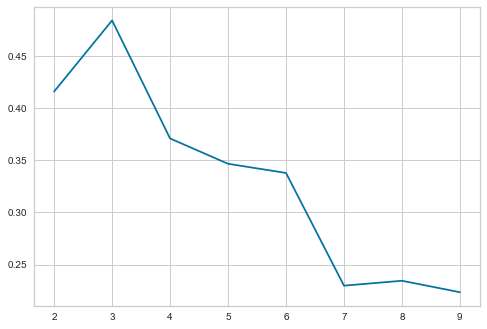

<IPython.core.display.Javascript object>

In [89]:
# Getting the silhouette scores to confirm my suspicions on the number of clusters
ward_sil_score = []
cluster_list = list(range(2, 10))
for n_clusters in cluster_list:
    clusterer = AgglomerativeClustering(
        n_clusters=n_clusters, affinity="euclidean", linkage="ward"
    )
    preds = clusterer.fit_predict((df_scaled))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(df_scaled, preds)
    ward_sil_score.append(score)
    print("For n_clusters = {}, the silhouette score is {})".format(n_clusters, score))

plt.plot(cluster_list, ward_sil_score)
plt.show()

Again 3 clusters seem to be the stand-out number of clusters based on silhouette score.

### Davies Bouldin Score

Text(0.5, 1.0, 'Davies Bouldin score vs. K')

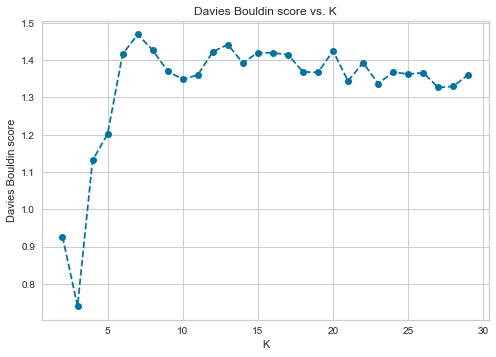

<IPython.core.display.Javascript object>

In [90]:
war_scores = []

for center in centers:
    war_scores.append(get_Hmeans_score(df_scaled, "euclidean", "ward", center))

plt.plot(centers, scores, linestyle="--", marker="o", color="b")
plt.xlabel("K")
plt.ylabel("Davies Bouldin score")
plt.title("Davies Bouldin score vs. K")

In [91]:
war_scores[1]

0.736113716356355

<IPython.core.display.Javascript object>

The DB score of 0.736 is the lowest at 3 clusters. A lower score is better, this implies 3 is the superior choice for number of clusters. We'll proceed with this number.

### Cluster Comparisons

In [92]:
# Creating the model for this method using 3 clusters to label the data
model = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="ward")
model.fit(df_scaled)

AgglomerativeClustering(n_clusters=3)

<IPython.core.display.Javascript object>

In [93]:
# labeling the data
df_labeled["Ward_labels"] = model.labels_

<IPython.core.display.Javascript object>

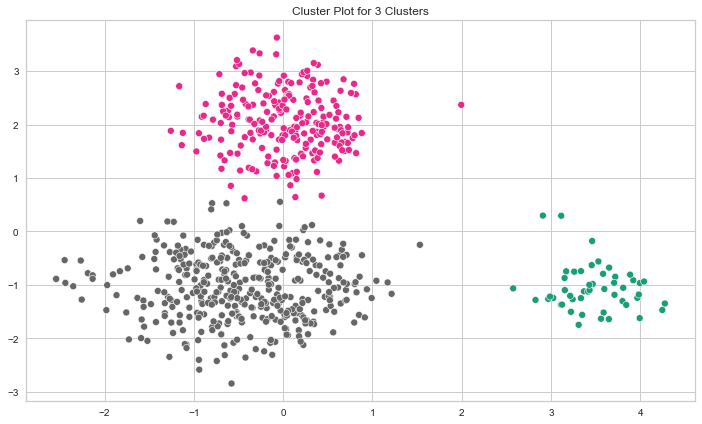

<IPython.core.display.Javascript object>

In [94]:
# Showing a PCA scatterplot of this method to make it comparable to other methods
pca_2 = PCA(2)
plot_columns = pca_2.fit_transform(df_scaled)
plt.figure(figsize=(12, 7))
sns.scatterplot(
    x=plot_columns[:, 1],
    y=plot_columns[:, 0],
    hue=AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="ward")
    .fit(df_scaled)
    .labels_,
    palette="Dark2_r",
    legend=False,
)
plt.title("Cluster Plot for 3 Clusters")
plt.show()

Again the few dots between 0 and 1 on the y axis seem to be flipping. Overall the grouping is very similar.

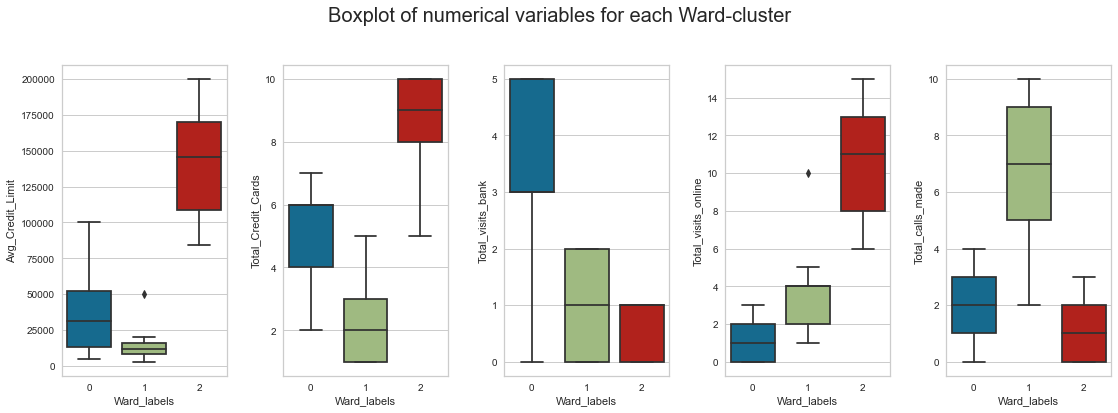

<IPython.core.display.Javascript object>

In [95]:
# Making box plots for each column by cluster so we can compare the clusters
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of numerical variables for each Ward-cluster", fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(
        ax=axes[ii], y=df_labeled[num_col[counter]], x=df_labeled["Ward_labels"],
    )
    counter = counter + 1

fig.tight_layout(pad=2.0)

In [96]:
df_labeled["Ward_labels"].value_counts()

0    386
1    224
2     50
Name: Ward_labels, dtype: int64

<IPython.core.display.Javascript object>

In [97]:
h_clusters = df_labeled.groupby(["Ward_labels"])

<IPython.core.display.Javascript object>

In [98]:
h_clusters.mean().round(2)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Avg_labels,H-labels_complete
Ward_labels,,,,,,,
0,33803.11,5.51,3.48,0.98,1.99,0.0,0.01
1,12138.39,2.42,0.94,3.56,6.88,2.0,1.98
2,141040.00,8.74,0.60,10.90,1.08,1.0,1.00


<IPython.core.display.Javascript object>

The cophenetic correlation is the lowest we've seen so far, implying it does not faithfully represent the trends in the data as well.

Otherwise the trends in the groups are identical as above.

In [99]:
# Finding the standard deviation just for reference.
h_clusters.std()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Avg_labels,H-labels_complete
Ward_labels,,,,,,,
0,22148.086973,1.146942,1.146884,0.855592,1.427901,0.0,0.101797
1,5256.944935,1.113620,0.804264,1.211391,1.960349,0.0,0.188558
2,34457.877272,1.274715,0.494872,2.880264,0.876915,0.0,0.000000


<IPython.core.display.Javascript object>

### Four Clusters Ward

I want to try four clusters just to be able to compare it to three.

In [100]:
# remaking the model with 4 clusters
model = AgglomerativeClustering(n_clusters=4, affinity="euclidean", linkage="ward")
model.fit(df_scaled)

AgglomerativeClustering(n_clusters=4)

<IPython.core.display.Javascript object>

In [101]:
# Adding the label to the data
df_labeled["Four_Ward"] = model.labels_

<IPython.core.display.Javascript object>

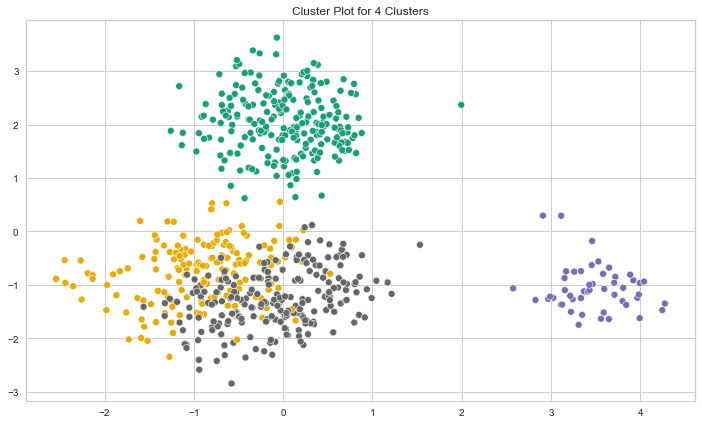

<IPython.core.display.Javascript object>

In [102]:
# Showing a PCA scatterplot of this method to make it comparable to other methods
pca_2 = PCA(2)
plot_columns = pca_2.fit_transform(df_scaled)
plt.figure(figsize=(12, 7))
sns.scatterplot(
    x=plot_columns[:, 1],
    y=plot_columns[:, 0],
    hue=AgglomerativeClustering(n_clusters=4, affinity="euclidean", linkage="ward")
    .fit(df_scaled)
    .labels_,
    palette="Dark2_r",
    legend=False,
)
plt.title("Cluster Plot for 4 Clusters")
plt.show()

Ugh look at that overlap on the lower left blob. Not good.

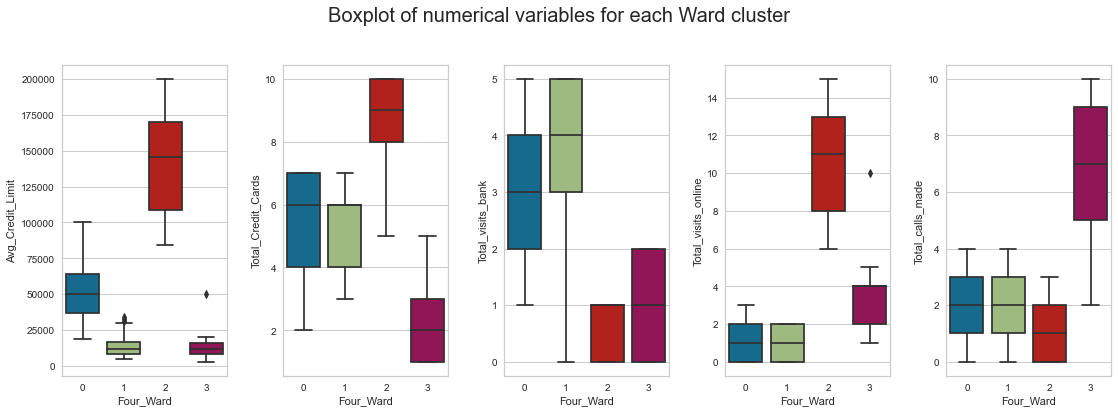

<IPython.core.display.Javascript object>

In [103]:
# Making box plots for each of the four categories
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of numerical variables for each Ward cluster", fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(
        ax=axes[ii], y=df_labeled[num_col[counter]], x=df_labeled["Four_Ward"],
    )
    counter = counter + 1

fig.tight_layout(pad=2.0)

In [104]:
# Seeing how well spread the data points are across the groups
df_labeled["Four_Ward"].value_counts()

3    224
0    216
1    170
2     50
Name: Four_Ward, dtype: int64

<IPython.core.display.Javascript object>

In [105]:
# Extracting the means for each group cross column
h_clusters = df_labeled.groupby(["Four_Ward"])

<IPython.core.display.Javascript object>

In [106]:
h_clusters.mean()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Avg_labels,H-labels_complete,Ward_labels
Four_Ward,,,,,,,,
0,50305.555556,5.532407,3.412037,0.958333,2.097222,0.0,0.000000,0.0
1,12835.294118,5.482353,3.576471,1.005882,1.858824,0.0,0.011765,0.0
2,141040.000000,8.740000,0.600000,10.900000,1.080000,1.0,1.000000,2.0
3,12138.392857,2.419643,0.941964,3.558036,6.883929,2.0,1.982143,1.0


<IPython.core.display.Javascript object>

With four clusters another group appears that seems similar to group 1 (the "in-person" group) except that they have higher average credit limits.

I don't feel like this is a meaningful cluster because it offers little insight into the behavior of the customer group. Average credit limit being slightly higher could be because of any number of factors, it is very difficult to link to behavior. I continue to believe 3 is the best cluster number.

Supporting my position that this is not as good of a clustering method for this data is the cophetic correlation remains substantially lower than the other methods so far.

In [107]:
# Finding the standard deviation just for reference.
h_clusters.std()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Avg_labels,H-labels_complete,Ward_labels
Four_Ward,,,,,,,,
0,15227.550511,1.164940,1.121313,0.853515,1.419070,0.0,0.000000,0.0
1,5673.246796,1.126462,1.175454,0.860006,1.432116,0.0,0.153393,0.0
2,34457.877272,1.274715,0.494872,2.880264,0.876915,0.0,0.000000,0.0
3,5256.944935,1.113620,0.804264,1.211391,1.960349,0.0,0.188558,0.0


<IPython.core.display.Javascript object>

## Single Linkage

In [108]:
# Creating linkages so that we can populate the dendrogram
Z = linkage(df_scaled, metric="euclidean", method="single")
c, coph_dists = cophenet(Z, pdist(df_scaled))

<IPython.core.display.Javascript object>

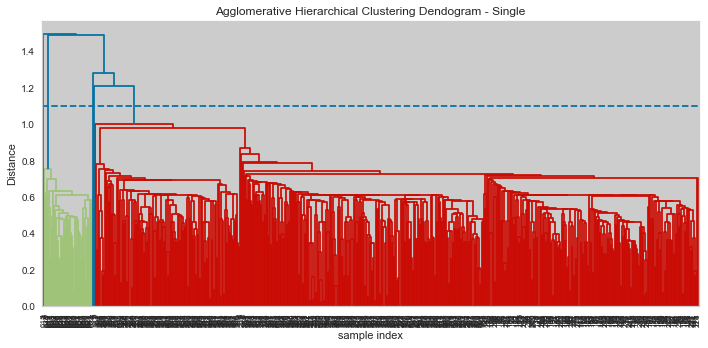

<IPython.core.display.Javascript object>

In [109]:
# Creating a dendrogram for the single linkage method
plt.figure(figsize=(10, 5))
plt.title("Agglomerative Hierarchical Clustering Dendogram - Single")
plt.xlabel("sample index")
plt.ylabel("Distance")
dendrogram(Z, leaf_rotation=90.0, color_threshold=1.1, leaf_font_size=8.0)
plt.tight_layout()
plt.axhline(y=1.1, linestyle="--")

In [110]:
c_single = c  # Saving for later comparisons
# displaying the cophnetic correlation
c

0.6183544852599758

<IPython.core.display.Javascript object>

This didn't seem to cluster all that well. What is going on between the first two groups? I think it's two or three points in their own cluster. Probably those two floating points between the three blobs.

The cophenetic correlation is also painfully low.

### Silhouette Scores

For n_clusters = 2, the silhouette score is 0.18252732040219002)
For n_clusters = 3, the silhouette score is 0.23377638003176432)
For n_clusters = 4, the silhouette score is 0.02834477803566942)
For n_clusters = 5, the silhouette score is -0.0008797461204257475)
For n_clusters = 6, the silhouette score is -0.025566465002177827)
For n_clusters = 7, the silhouette score is 0.0006541556455662022)
For n_clusters = 8, the silhouette score is -0.03982658635264336)
For n_clusters = 9, the silhouette score is -0.05189224531200011)


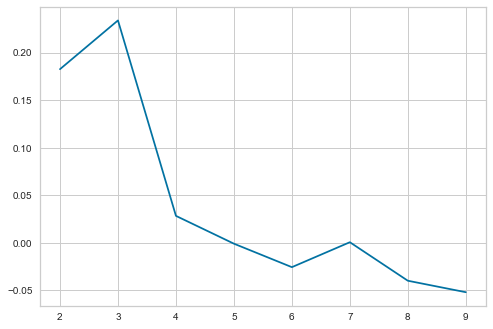

<IPython.core.display.Javascript object>

In [111]:
# Getting the silhouette scores to confirm my suspicions on the number of clusters
single_sil_score = []
cluster_list = list(range(2, 10))
for n_clusters in cluster_list:
    clusterer = AgglomerativeClustering(
        n_clusters=n_clusters, affinity="euclidean", linkage="single"
    )
    preds = clusterer.fit_predict((df_scaled))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(df_scaled, preds)
    single_sil_score.append(score)
    print("For n_clusters = {}, the silhouette score is {})".format(n_clusters, score))

plt.plot(cluster_list, single_sil_score)
plt.show()

The number of clusters remains clear: Three.

### Davies Bouldin Score

Text(0.5, 1.0, 'Davies Bouldin score vs. K')

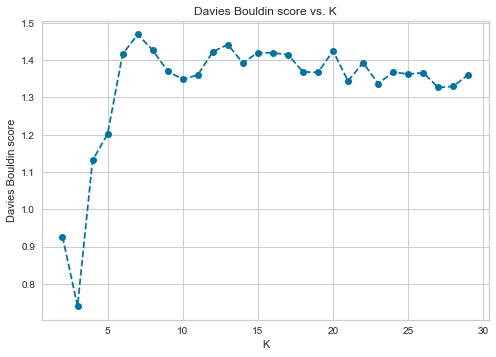

<IPython.core.display.Javascript object>

In [112]:
sin_scores = []

for center in centers:
    sin_scores.append(get_Hmeans_score(df_scaled, "euclidean", "single", center))

plt.plot(centers, scores, linestyle="--", marker="o", color="b")
plt.xlabel("K")
plt.ylabel("Davies Bouldin score")
plt.title("Davies Bouldin score vs. K")

In [113]:
sin_scores[1]

0.660732573577179

<IPython.core.display.Javascript object>

The DB score of .661 is lowest at 3 clusters. A lower score is better, this implies 3 is the superior choice for number of clusters. We'll proceed with this number.

### Comparing the Clusters

In [114]:
# Fitting the model for the single linkage method
model = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="single")
model.fit(df_scaled)

AgglomerativeClustering(linkage='single', n_clusters=3)

<IPython.core.display.Javascript object>

In [115]:
# Adding labels to the data
df_labeled["Single_labels"] = model.labels_

<IPython.core.display.Javascript object>

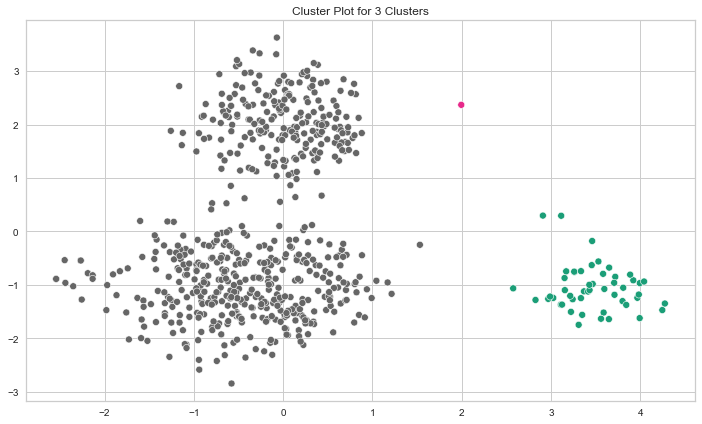

<IPython.core.display.Javascript object>

In [116]:
# Showing a PCA scatterplot of this method to make it comparable to other methods
pca_2 = PCA(2)
plot_columns = pca_2.fit_transform(df_scaled)
plt.figure(figsize=(12, 7))
sns.scatterplot(
    x=plot_columns[:, 1],
    y=plot_columns[:, 0],
    hue=AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="single")
    .fit(df_scaled)
    .labels_,
    palette="Dark2_r",
    legend=False,
)
plt.title("Cluster Plot for 3 Clusters")
plt.show()

That just made me laugh. One cluster is literally one data point. I mean, it is obviously an outlier, but to not split the left two blobs is poor performance.

This method is just not good.

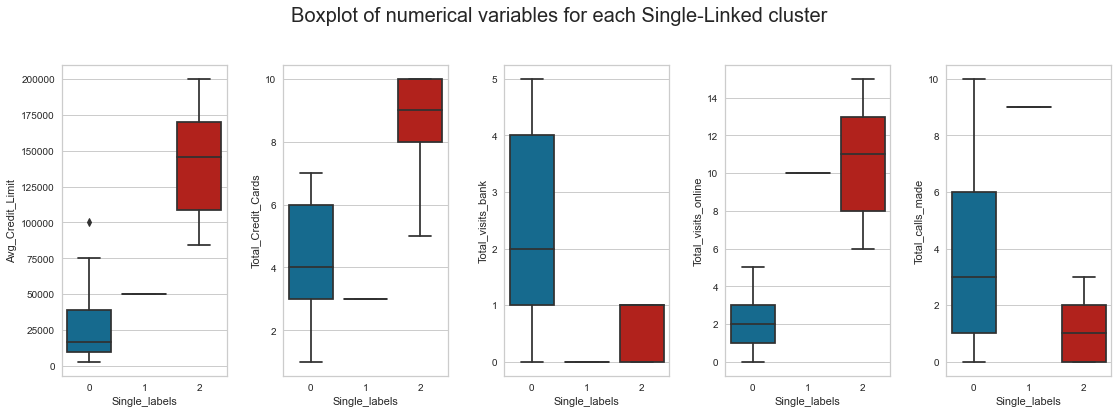

<IPython.core.display.Javascript object>

In [117]:
# Let's see how the "three" groups look across the columns via box plots
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle(
    "Boxplot of numerical variables for each Single-Linked cluster", fontsize=20
)
counter = 0
for ii in range(5):
    sns.boxplot(
        ax=axes[ii], y=df_labeled[num_col[counter]], x=df_labeled["Single_labels"],
    )
    counter = counter + 1

fig.tight_layout(pad=2.0)

In [118]:
# Checking counts to see if it is really just one value in group 1.
df_labeled["Single_labels"].value_counts()

0    609
2     50
1      1
Name: Single_labels, dtype: int64

<IPython.core.display.Javascript object>

In [119]:
# Extracting means for comparisons
h_clusters = df_labeled.groupby(["Single_labels"])

<IPython.core.display.Javascript object>

In [120]:
h_clusters.mean()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Avg_labels,H-labels_complete,Ward_labels,Four_Ward
Single_labels,,,,,,,,,
0,25807.881773,4.377668,2.555008,1.912972,3.779967,0.732348,0.729064,0.366174,1.377668
1,50000.000000,3.000000,0.000000,10.000000,9.000000,2.000000,2.000000,1.000000,3.000000
2,141040.000000,8.740000,0.600000,10.900000,1.080000,1.000000,1.000000,2.000000,2.000000


<IPython.core.display.Javascript object>

The cophenetic correlation is very weak, and the dendogram is quite unclear. This method put almost all cases into a single group, with one grouping having only a lone person.

This linkage method clearly is not suitable for this data set.

In [121]:
# Finding the standard deviation just for reference.
h_clusters.std()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Avg_labels,H-labels_complete,Ward_labels,Four_Ward
Single_labels,,,,,,,,,
0,20717.576212,1.873963,1.602017,1.563559,2.869565,0.964308,0.963389,0.482154,1.295955
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,34457.877272,1.274715,0.494872,2.880264,0.876915,0.000000,0.000000,0.000000,0.000000


<IPython.core.display.Javascript object>

Can't have a variance if there is only one value. That's what those NaN are.

# Comparing Hierarchical Methods

For each of the methods, 3 clusters was optimal. I'm going to take the silhouette scores for each method and compare them to help decide which is best.

In [122]:
# Loading saved silhouette scores, only selecting the highest
sil_scores = [
    avg_sil_score[1],
    complete_sil_score[1],
    ward_sil_score[1],
    single_sil_score[1],
]
# Loading saved cophenetic correlations
c_scores = [c_average, c_complete, c_ward, c_single]

# Loading all Davies Bouldin scores
DB_scores = [avg_scores[1], com_scores[1], war_scores[1], sin_scores[1]]

# Making labels for each method
Methods = ["Average", "Complete", "Ward", "Single"]

# Creating a dataframe for comparisons
compare = pd.DataFrame(
    {
        "Silhouette Score": sil_scores,
        "Cophenetic Correlation": c_scores,
        "Davis Bouldin Score": DB_scores,
    },
    index=Methods,
)
# Displaying comparison
compare

,Silhouette Score,Cophenetic Correlation,Davis Bouldin Score
Average,0.483947,0.849273,0.736114
Complete,0.483457,0.810166,0.736088
Ward,0.483947,0.764678,0.736114
Single,0.233776,0.618354,0.660733


<IPython.core.display.Javascript object>

Of the four methods available in this library, Average and Ward have the best silhouette score. Their DB score is the same as well. But, of those, Average has the highest cophenetic correlation. This implies the Average method will give us the most accurate clustering of the data of the compared methods. Now we just need to compare the best of these hierarchical methods to k-means.

# Comparing K-Means and Hierarchical

Clustering is ultimately a subjective judgment. Using both of these methods, we found they captured similar trends. The question then becomes, which one captured them better? To do this, I want to look at those customers the algorithm had difficulty clustering.

For this comparison we're going to use the best hiearchical model we found, which was the average method (H-labels).

### Quantitative Comparison

One way we can compare the methods is through their various scores. After all, silhouette scores measure the same thing whether it was from hierarcichal clustering or k-means, so let's take a look.

In [123]:
# Loading saved silhouette scores, only selecting the highest
sil_com = [sil_score[1], avg_sil_score[1]]

# Loading all Davies Bouldin scores
DB_scores = [scores[1], avg_scores[1]]

# Making labels for each method
types = ["K-means", "Average Hierarchical"]

# Creating a dataframe for comparisons
cross_compare = pd.DataFrame(
    {"Silhouette Score": sil_com, "Davis Bouldin Score": DB_scores}, index=types,
)
# Displaying comparison
cross_compare

,Silhouette Score,Davis Bouldin Score
K-means,0.483562,0.739921
Average Hierarchical,0.483947,0.736114


<IPython.core.display.Javascript object>

Silhouette scores should be high, and DB scores should be low. The average linkage method for hierarchical clustering beat out k-means both times just barely.

### Qualitative Comparison

Numbers aren't enough, a lot of clustering is subjective. I'm going to look at which points the two methods differed on.

As a reminder, both methods found 3 clusters were optimal, and each had three different profiles: The in-person customer who visits the bank in person, the vocalizer who calls frequently, and the online group who makes use of the bank's online tools.

By checking the edge cases, we can assess which method is superior.

In [124]:
# When "in person" clusters are different.
# The in-person group was 1 for k-means and 0 for hierarchical

df_labeled[(df_labeled["k_labels"] == 1) & (df_labeled["Avg_labels"] != 0)].sum()

Avg_Credit_Limit       0.0
Total_Credit_Cards     0.0
Total_visits_bank      0.0
Total_visits_online    0.0
Total_calls_made       0.0
Avg_labels             0.0
H-labels_complete      0.0
Ward_labels            0.0
Four_Ward              0.0
Single_labels          0.0
dtype: float64

<IPython.core.display.Javascript object>

The two clustering algorithms were identical for the in-person group. There is no difference here.

In [125]:
# When "vocalizer" clusters are different.
# The vocalizer group was 0 for k-means and 2 for hierarchical
df_labeled[(df_labeled["k_labels"] == 0) & (df_labeled["Avg_labels"] != 2)]

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,k_labels,Avg_labels,H-labels_complete,Ward_labels,Four_Ward,Single_labels
7,15000,3,0,1,1,0,0,2,0,1,0


<IPython.core.display.Javascript object>

There is only one case where the algorithms differed in opinion on whether someone was a vocalizer or not. In the case of the hierarchical model, it believed this person was an in-person visitor.

However, this clearly isn't the case: the person never visited the bank in person. Additionally, the other parameters are well within the ranges of group 2 (vocalizer).

It can't be in the online group because the credit limit is much too low, as are the number of credit cards.

To me, this is just an error. One strike for hierarchical.

In [126]:
df_labeled[(df_labeled["k_labels"] == 2) & (df_labeled["Avg_labels"] != 1)]

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,k_labels,Avg_labels,H-labels_complete,Ward_labels,Four_Ward,Single_labels
2,50000,7,1,3,4,2,0,0,0,0,0


<IPython.core.display.Javascript object>

The "online" group is characterized by high credit limits, lots of credit cards, and high online usage. I can see why this person was hard to label, as their bank interactions were very similar in quantity.

The problem with this person is that even though their in-person visits is low, their credit limit and total credit card number aligns much more with the in-person category than the other categories. There is a strong case to be made for them to be in-person.

It's a tough call but I think k-means got this one wrong. It's a big grey area, though, for sure.

### Comparison Conclusion

Overall I think the K-means clustering method performed better subjectively. While the second difference was quite uncertain, the first difference was very clear. Thus, while they performed similarly, I prefer K-means on this measure.

The hierarchical method did better slightly quantitatively, with superior a superior silhouette score and DB score. However, this advantage was very small.

The current database is extremely small. As it increases in size, the agglomerative clustering method becomes more and more computationally intense. Meanwhile, k-means is appropriate to use even on large amounts of data.

It is thus my opinion that the ever-so-slighty better performance of the agglomerative clustering method does not justify being brought into production for classifying future customers. Its performance is too close to k-means to warrant the extra computing power.

I recommend continuing with the k-means model.

# Business Insights

In conclusion, we are left with the following three groups (reprinted for convenience)

Group 0: Vocalizers
* Second largest group
* Very low credit limit
* Low number of credit cards
* Almost never visits the bank or uses online services
* Huge number of calls made


Group 1: In-Person
* Largest group
* Mid number of credit cards
* Visits the bank often
* Almost no online usage
* Calls rarely

Group 2: Online
* Smallest group, and by a large margine
* Huge credit limit
* Lots of credit cards
* Almost never visits the bank
* Banks online extensively
* Almost never calls

The stated goal was to increase market penetration. Based on this, one primary recommendation becomes clear: The online tools are vastly underused.

Of the three groups, the online group is substantially smaller than the other two, at only 50 members. This means that those with high credit limits and who frequently use the online tools are not being attracted to the bank.

Furthermore, the unattractiveness of the online tools is similarly demonstrated by the other groups not using it. There is no reason people with few numbers of credit cards or low credit limits can't use the online banking tools. It strongly implies that the bank's online system has usability issues.

This suggests a two-pronged approach to increase market penetration:

1. Improve the usability and utility of the online banking tools
2. Advertise online and elsewhere to attract customers who prefer a robust online banking experience.

The other groups can be catered to similarly by improving the experiences of their preferred contact method. Ensure high-quality phone services during many hours of the day for vocalizers, and lengthen opening-hours and cut down on waiting times for those preferring in-person visits.

Those improvements can be quite expensive, however, so encouraging the vocalizers and the in-person group to use online tools more would probably be the most cost-effective route.

For example: Online is not split into multiple categories, implying only one form of online interaction is used. Logging in and manipulating one's account via a web servic is basic, and many people may only need this service. However, vocalizers and in-person customers, the vast majority of the current customer base, seem to require/prefer personal interaction. Thus, offering a "chat with a support agent" option online could be beneficial, and may be cheaper than hiring extra staff to work at the physical location to reduce wait times.